## Setup

In [1]:
topology = 'B'
omission = 'omitExMet'

In [2]:
from scipy.stats import f_oneway
from scipy.stats import kruskal

import pandas as pd
import numpy as np
import tellurium as te

import random

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.multivariate.manova import MANOVA

import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

import gzip
import cloudpickle

In [3]:
os.chdir('..')
from src import antemll, util
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
ant_noReg ='../models/Antimony/topologyB-noReg.ant' 
ant_reg1 ='../models/Antimony/topologyB-reg1.ant'
ant_reg2 ='../models/Antimony/topologyB-reg2.ant' 

rr_noReg = te.loada(ant_noReg)
rr_noReg.conservedMoietyAnalysis = True
rr_noReg.steadyState()

rr_reg1 = te.loada(ant_reg1)
rr_reg1.conservedMoietyAnalysis = True
rr_reg1.steadyState()

rr_reg2 = te.loada(ant_reg2)
rr_reg2.conservedMoietyAnalysis = True
rr_reg2.steadyState()

gt_noReg = rr_noReg.getScaledElasticityMatrix().ravel()
gt_reg1 = rr_reg1.getScaledElasticityMatrix().ravel()
gt_reg2 = rr_reg2.getScaledElasticityMatrix().ravel()

In [5]:
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [6]:
datafile01_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.1.csv'
datafile02_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.2.csv'
datafile03_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.3.csv'
datafile04_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.4.csv'
datafile05_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_0.5.csv'
datafile15_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_1.5.csv'
datafile3_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_3.csv'
datafile5_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_5.csv'
datafile7_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_7.csv'
datafile100_noReg = f'../data/interim/generated_data/Topology{topology}-noReg/Topology{topology}-noReg_10.csv'

datafile01_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.1.csv'
datafile02_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.2.csv'
datafile03_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.3.csv'
datafile04_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.4.csv'
datafile05_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_0.5.csv'
datafile15_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_1.5.csv'
datafile3_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_3.csv'
datafile5_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_5.csv'
datafile7_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_7.csv'
datafile100_reg1 = f'../data/interim/generated_data/Topology{topology}-reg1/Topology{topology}-reg1_10.csv'

datafile01_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.1.csv'
datafile02_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.2.csv'
datafile03_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.3.csv'
datafile04_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.4.csv'
datafile05_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_0.5.csv'
datafile15_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_1.5.csv'
datafile3_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_3.csv'
datafile5_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_5.csv'
datafile7_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_7.csv'
datafile100_reg2 = f'../data/interim/generated_data/Topology{topology}-reg2/Topology{topology}-reg2_10.csv'


In [7]:
BMCA_obj01_noReg = antemll.antemll(ant_noReg, datafile01_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj02_noReg = antemll.antemll(ant_noReg, datafile02_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj03_noReg = antemll.antemll(ant_noReg, datafile03_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj04_noReg = antemll.antemll(ant_noReg, datafile04_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj05_noReg = antemll.antemll(ant_noReg, datafile05_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj15_noReg = antemll.antemll(ant_noReg, datafile15_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj3_noReg = antemll.antemll(ant_noReg, datafile3_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj5_noReg = antemll.antemll(ant_noReg, datafile5_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj7_noReg = antemll.antemll(ant_noReg, datafile7_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj100_noReg = antemll.antemll(ant_noReg, datafile100_noReg, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')

BMCA_obj01_reg1 = antemll.antemll(ant_reg1, datafile01_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj02_reg1 = antemll.antemll(ant_reg1, datafile02_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj03_reg1 = antemll.antemll(ant_reg1, datafile03_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj04_reg1 = antemll.antemll(ant_reg1, datafile04_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj05_reg1 = antemll.antemll(ant_reg1, datafile05_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj15_reg1 = antemll.antemll(ant_reg1, datafile15_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj3_reg1 = antemll.antemll(ant_reg1, datafile3_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj5_reg1 = antemll.antemll(ant_reg1, datafile5_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj7_reg1 = antemll.antemll(ant_reg1, datafile7_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj100_reg1 = antemll.antemll(ant_reg1, datafile100_reg1, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')

BMCA_obj01_reg2 = antemll.antemll(ant_reg2, datafile01_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj02_reg2 = antemll.antemll(ant_reg2, datafile02_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj03_reg2 = antemll.antemll(ant_reg2, datafile03_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj04_reg2 = antemll.antemll(ant_reg2, datafile04_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj05_reg2 = antemll.antemll(ant_reg2, datafile05_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj15_reg2 = antemll.antemll(ant_reg2, datafile15_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj3_reg2 = antemll.antemll(ant_reg2, datafile3_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj5_reg2 = antemll.antemll(ant_reg2, datafile5_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj7_reg2 = antemll.antemll(ant_reg2, datafile7_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')
BMCA_obj100_reg2 = antemll.antemll(ant_reg2, datafile100_reg2, cobra_sbml=f'../models/sbml/Topology{topology}_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../models/Antimony/topologyB_cobra.ant


## Downloading all the trace files

In [8]:
picklefolder = '../data/results/tracePickles/'
oldpicklefolder = '../data/results/tracePickles-20240801/'

In [9]:
with gzip.open(picklefolder + f'topologyB-noReg_{omission}_traces.pgz', "rb") as f:
    traces_noReg = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + f'topologyB-reg1_{omission}_traces.pgz', "rb") as f:
    traces_reg1 = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + f'topologyB-reg2_{omission}_traces.pgz', "rb") as f:
    traces_reg2 = cloudpickle.load(f, encoding='bytes')

In [10]:
trace01_noReg=traces_noReg['trace01']
trace02_noReg=traces_noReg['trace02']
trace03_noReg=traces_noReg['trace03']
trace04_noReg=traces_noReg['trace04']
trace05_noReg=traces_noReg['trace05']
trace15_noReg=traces_noReg['trace15']
trace3_noReg=traces_noReg['trace3']
trace5_noReg=traces_noReg['trace5']
trace7_noReg=traces_noReg['trace7']
trace10_noReg=traces_noReg['trace100']

trace01_reg1=traces_reg1['trace01']
trace02_reg1=traces_reg1['trace02']
trace03_reg1=traces_reg1['trace03']
trace04_reg1=traces_reg1['trace04']
trace05_reg1=traces_reg1['trace05']
trace15_reg1=traces_reg1['trace15']
trace3_reg1=traces_reg1['trace3']
trace5_reg1=traces_reg1['trace5']
trace7_reg1=traces_reg1['trace7']
trace10_reg1=traces_reg1['trace100']

trace01_reg2=traces_reg2['trace01']
trace02_reg2=traces_reg2['trace02']
trace03_reg2=traces_reg2['trace03']
trace04_reg2=traces_reg2['trace04']
trace05_reg2=traces_reg2['trace05']
trace15_reg2=traces_reg2['trace15']
trace3_reg2=traces_reg2['trace3']
trace5_reg2=traces_reg2['trace5']
trace7_reg2=traces_reg2['trace7']
trace10_reg2=traces_reg2['trace100']

## establishing elasticity means

In [11]:
if omission == 'allData':
    # for all data
    Ex01_noReg = util.get_az_summary(trace01_noReg)
    Ex01_reg1 = util.get_az_summary(trace01_reg1)
    Ex01_reg2 = util.get_az_summary(trace01_reg2)

    Ex02_noReg = util.get_az_summary(trace02_noReg)
    Ex02_reg1 = util.get_az_summary(trace02_reg1)
    Ex02_reg2 = util.get_az_summary(trace02_reg2)

    Ex03_noReg = util.get_az_summary(trace03_noReg)
    Ex03_reg1 = util.get_az_summary(trace03_reg1)
    Ex03_reg2 = util.get_az_summary(trace03_reg2)

    Ex04_noReg = util.get_az_summary(trace04_noReg)
    Ex04_reg1 = util.get_az_summary(trace04_reg1)
    Ex04_reg2 = util.get_az_summary(trace04_reg2)

    Ex05_noReg = util.get_az_summary(trace05_noReg)
    Ex05_reg1 = util.get_az_summary(trace05_reg1)
    Ex05_reg2 = util.get_az_summary(trace05_reg2)

    Ex15_noReg = util.get_az_summary(trace15_noReg)
    Ex15_reg1 = util.get_az_summary(trace15_reg1)
    Ex15_reg2 = util.get_az_summary(trace15_reg2)

    Ex3_noReg = util.get_az_summary(trace3_noReg)
    Ex3_reg1 = util.get_az_summary(trace3_reg1)
    Ex3_reg2 = util.get_az_summary(trace3_reg2)

    Ex5_noReg = util.get_az_summary(trace5_noReg)
    Ex5_reg1 = util.get_az_summary(trace5_reg1)
    Ex5_reg2 = util.get_az_summary(trace5_reg2)

    Ex7_noReg = util.get_az_summary(trace7_noReg)
    Ex7_reg1 = util.get_az_summary(trace7_reg1)
    Ex7_reg2 = util.get_az_summary(trace7_reg2)

    Ex100_noReg = util.get_az_summary(trace10_noReg)
    Ex100_reg1 = util.get_az_summary(trace10_reg1)
    Ex100_reg2 = util.get_az_summary(trace10_reg2)

else:
    # for omitted data
    Ex01_noReg = util.get_az_mean(trace01_noReg)
    Ex01_reg1 = util.get_az_mean(trace01_reg1)
    Ex01_reg2 = util.get_az_mean(trace01_reg2)

    Ex02_noReg = util.get_az_mean(trace02_noReg)
    Ex02_reg1 = util.get_az_mean(trace02_reg1)
    Ex02_reg2 = util.get_az_mean(trace02_reg2)

    Ex03_noReg = util.get_az_mean(trace03_noReg)
    Ex03_reg1 = util.get_az_mean(trace03_reg1)
    Ex03_reg2 = util.get_az_mean(trace03_reg2)

    Ex04_noReg = util.get_az_mean(trace04_noReg)
    Ex04_reg1 = util.get_az_mean(trace04_reg1)
    Ex04_reg2 = util.get_az_mean(trace04_reg2)

    Ex05_noReg = util.get_az_mean(trace05_noReg)
    Ex05_reg1 = util.get_az_mean(trace05_reg1)
    Ex05_reg2 = util.get_az_mean(trace05_reg2)

    Ex15_noReg = util.get_az_mean(trace15_noReg)
    Ex15_reg1 = util.get_az_mean(trace15_reg1)
    Ex15_reg2 = util.get_az_mean(trace15_reg2)

    Ex3_noReg = util.get_az_mean(trace3_noReg)
    Ex3_reg1 = util.get_az_mean(trace3_reg1)
    Ex3_reg2 = util.get_az_mean(trace3_reg2)

    Ex5_noReg = util.get_az_mean(trace5_noReg)
    Ex5_reg1 = util.get_az_mean(trace5_reg1)
    Ex5_reg2 = util.get_az_mean(trace5_reg2)

    Ex7_noReg = util.get_az_mean(trace7_noReg)
    Ex7_reg1 = util.get_az_mean(trace7_reg1)
    Ex7_reg2 = util.get_az_mean(trace7_reg2)

    Ex100_noReg = util.get_az_mean(trace10_noReg)
    Ex100_reg1 = util.get_az_mean(trace10_reg1)
    Ex100_reg2 = util.get_az_mean(trace10_reg2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [118]:
# free

## organizing elasticity values into pd dfs 

In [12]:
ela_noReg_values = np.column_stack([Ex01_noReg, Ex02_noReg, Ex03_noReg, 
                                Ex04_noReg, Ex05_noReg,  
                                Ex15_noReg, Ex3_noReg, Ex5_noReg, 
                                Ex7_noReg, Ex100_noReg])

ela_reg1_values = np.column_stack([Ex01_reg1, Ex02_reg1, Ex03_reg1, 
                                Ex04_reg1, Ex05_reg1,  
                                Ex15_reg1, Ex3_reg1, Ex5_reg1, 
                                Ex7_reg1, Ex100_reg1])

ela_reg2_values = np.column_stack([Ex01_reg2, Ex02_reg2, Ex03_reg2, 
                                Ex04_reg2, Ex05_reg2,  
                                Ex15_reg2, Ex3_reg2, Ex5_reg2, 
                                Ex7_reg2, Ex100_reg2])

pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

ela_noReg_df = pd.DataFrame(ela_noReg_values, columns=pt_labels)
ela_reg1_df = pd.DataFrame(ela_reg1_values, columns=pt_labels)
ela_reg2_df = pd.DataFrame(ela_reg2_values, columns=pt_labels)

ela_noReg_df['median'] = ela_noReg_df.median(axis=1)
ela_noReg_df['min'] = ela_noReg_df.min(axis=1)
ela_noReg_df['max'] = ela_noReg_df.max(axis=1)

ela_reg1_df['median'] = ela_reg1_df.median(axis=1)
ela_reg1_df['min'] = ela_reg1_df.min(axis=1)
ela_reg1_df['max'] = ela_reg1_df.max(axis=1)

ela_reg2_df['median'] = ela_reg2_df.median(axis=1)
ela_reg2_df['min'] = ela_reg2_df.min(axis=1)
ela_reg2_df['max'] = ela_reg2_df.max(axis=1)

## graphing the elasticity predictions over perturbation level and regulator level

In [12]:
lower_y_noReg = np.array(ela_noReg_df['median']) - ela_noReg_df['min'].values
upper_y_noReg =np.array(ela_noReg_df['max'].values) - np.array(ela_noReg_df['median'])
errors_noReg = [lower_y_noReg, upper_y_noReg]

lower_y_reg1 = np.array(ela_reg1_df['median']) - ela_reg1_df['min'].values
upper_y_reg1 =np.array(ela_reg1_df['max'].values) - np.array(ela_reg1_df['median'])
errors_reg1 = [lower_y_reg1, upper_y_reg1]

lower_y_reg2 = np.array(ela_reg2_df['median']) - ela_reg2_df['min'].values
upper_y_reg2 =np.array(ela_reg2_df['max'].values) - np.array(ela_reg2_df['median'])
errors_reg2 = [lower_y_reg2, upper_y_reg2]


In [13]:
# MAE
print(round(sum(abs(ela_noReg_df['median']-gt_noReg))/len(gt_noReg),5))
print(round(sum(abs(ela_noReg_df['median']-gt_reg1))/len(gt_reg1),5))
print(round(sum(abs(ela_noReg_df['median']-gt_reg2))/len(gt_reg2),5))

0.12665
0.20864
0.32867


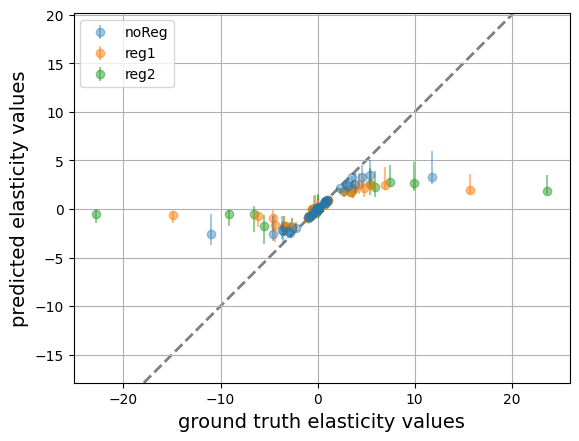

In [14]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gt_noReg, ela_noReg_df['median'], yerr=errors_noReg, alpha=0.4, fmt='o', label='noReg', zorder=100)
plt.errorbar(gt_reg1, ela_reg1_df['median'], yerr=errors_reg1, alpha=0.5, fmt='o', label='reg1', zorder=50)
plt.errorbar(gt_reg2, ela_reg2_df['median'], yerr=errors_reg2, alpha=0.5, fmt='o', label='reg2', zorder=20)
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedElasticities.svg', format="svg")

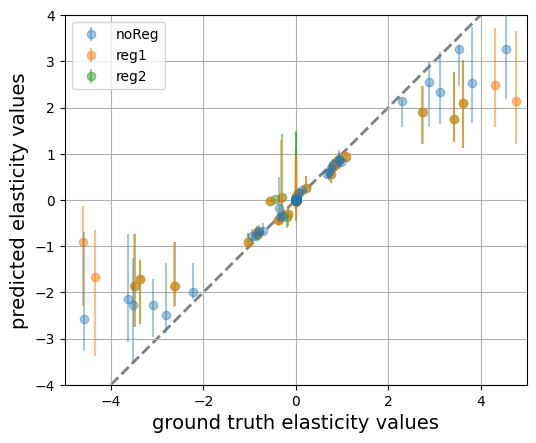

In [15]:
#plt.figure(figsize=(8, 6))
plt.axes().set_aspect('equal')
plt.xlim((-5,5))
plt.ylim((-4,4))

plt.errorbar(gt_noReg, ela_noReg_df['median'], yerr=errors_noReg, alpha=0.4, fmt='o', label='noReg', zorder=100)
plt.errorbar(gt_reg1, ela_reg1_df['median'], yerr=errors_reg1, alpha=0.5, fmt='o', label='reg1', zorder=50)
plt.errorbar(gt_reg2, ela_reg2_df['median'], yerr=errors_reg2, alpha=0.5, fmt='o', label='reg2', zorder=20)
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedElasticities_zoom.svg', format="svg")

### graphing the elasticity errors

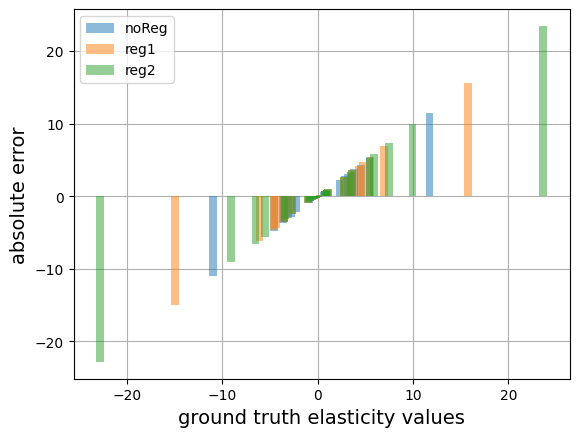

In [13]:
plt.grid()

plt.bar(gt_noReg,gt_noReg-ela_noReg_df['median'], alpha=0.5, label='noReg', zorder=200)
plt.bar(gt_reg1,gt_reg1-ela_reg1_df['median'], alpha=0.5, label='reg1', zorder=200)
plt.bar(gt_reg2,gt_reg2-ela_reg2_df['median'], alpha=0.5, label='reg2', zorder=200)

plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('absolute error', size=14)

plt.legend(loc="upper left")

## Calculating control coefficients

In [13]:
Ex01_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_noReg)['prior']['Ex'])
Ex02_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_noReg)['prior']['Ex'])
Ex03_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_noReg)['prior']['Ex'])
Ex04_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_noReg)['prior']['Ex'])
Ex05_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_noReg)['prior']['Ex'])
Ex15_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_noReg)['prior']['Ex'])
Ex3_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_noReg)['prior']['Ex'])
Ex5_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_noReg)['prior']['Ex'])
Ex7_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_noReg)['prior']['Ex'])
Ex100_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_noReg)['prior']['Ex'])

Ex01_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_reg1)['prior']['Ex'])
Ex02_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_reg1)['prior']['Ex'])
Ex03_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_reg1)['prior']['Ex'])
Ex04_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_reg1)['prior']['Ex'])
Ex05_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_reg1)['prior']['Ex'])
Ex15_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_reg1)['prior']['Ex'])
Ex3_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_reg1)['prior']['Ex'])
Ex5_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_reg1)['prior']['Ex'])
Ex7_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_reg1)['prior']['Ex'])
Ex100_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_reg1)['prior']['Ex'])

Ex01_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_reg2)['prior']['Ex'])
Ex02_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_reg2)['prior']['Ex'])
Ex03_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_reg2)['prior']['Ex'])
Ex04_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_reg2)['prior']['Ex'])
Ex05_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_reg2)['prior']['Ex'])
Ex15_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_reg2)['prior']['Ex'])
Ex3_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_reg2)['prior']['Ex'])
Ex5_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_reg2)['prior']['Ex'])
Ex7_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_reg2)['prior']['Ex'])
Ex100_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_reg2)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

## Calculating CCC values and making graphs

In [14]:
gtCCC_noReg = pd.DataFrame(rr_noReg.getScaledConcentrationControlCoefficientMatrix(), index=rr_noReg.getFloatingSpeciesIds(), columns=rr_noReg.getReactionIds())
gtCCC_reg1 = pd.DataFrame(rr_reg1.getScaledConcentrationControlCoefficientMatrix(), index=rr_noReg.getFloatingSpeciesIds(), columns=rr_noReg.getReactionIds())
gtCCC_reg2 = pd.DataFrame(rr_reg2.getScaledConcentrationControlCoefficientMatrix(), index=rr_noReg.getFloatingSpeciesIds(), columns=rr_noReg.getReactionIds())

### priors

In [15]:
priorCCC01_noReg = util.estimate_CCCs(BMCA_obj01_noReg, Ex01_prior_noReg.reshape((19,-1)))
priorCCC02_noReg = util.estimate_CCCs(BMCA_obj02_noReg, Ex02_prior_noReg.reshape((19,-1)))
priorCCC03_noReg = util.estimate_CCCs(BMCA_obj03_noReg, Ex03_prior_noReg.reshape((19,-1)))
priorCCC04_noReg = util.estimate_CCCs(BMCA_obj04_noReg, Ex04_prior_noReg.reshape((19,-1)))
priorCCC05_noReg = util.estimate_CCCs(BMCA_obj05_noReg, Ex05_prior_noReg.reshape((19,-1)))
priorCCC15_noReg = util.estimate_CCCs(BMCA_obj15_noReg, Ex15_prior_noReg.reshape((19,-1)))
priorCCC3_noReg = util.estimate_CCCs(BMCA_obj3_noReg, Ex3_prior_noReg.reshape((19,-1)))
priorCCC5_noReg = util.estimate_CCCs(BMCA_obj5_noReg, Ex5_prior_noReg.reshape((19,-1)))
priorCCC7_noReg = util.estimate_CCCs(BMCA_obj7_noReg, Ex7_prior_noReg.reshape((19,-1)))
priorCCC100_noReg = util.estimate_CCCs(BMCA_obj100_noReg, Ex100_prior_noReg.reshape((19,-1)))

priorCCC01_reg1 = util.estimate_CCCs(BMCA_obj01_reg1, Ex01_prior_reg1.reshape((19,-1)))
priorCCC02_reg1 = util.estimate_CCCs(BMCA_obj02_reg1, Ex02_prior_reg1.reshape((19,-1)))
priorCCC03_reg1 = util.estimate_CCCs(BMCA_obj03_reg1, Ex03_prior_reg1.reshape((19,-1)))
priorCCC04_reg1 = util.estimate_CCCs(BMCA_obj04_reg1, Ex04_prior_reg1.reshape((19,-1)))
priorCCC05_reg1 = util.estimate_CCCs(BMCA_obj05_reg1, Ex05_prior_reg1.reshape((19,-1)))
priorCCC15_reg1 = util.estimate_CCCs(BMCA_obj15_reg1, Ex15_prior_reg1.reshape((19,-1)))
priorCCC3_reg1 = util.estimate_CCCs(BMCA_obj3_reg1, Ex3_prior_reg1.reshape((19,-1)))
priorCCC5_reg1 = util.estimate_CCCs(BMCA_obj5_reg1, Ex5_prior_reg1.reshape((19,-1)))
priorCCC7_reg1 = util.estimate_CCCs(BMCA_obj7_reg1, Ex7_prior_reg1.reshape((19,-1)))
priorCCC100_reg1 = util.estimate_CCCs(BMCA_obj100_reg1, Ex100_prior_reg1.reshape((19,-1)))

priorCCC01_reg2 = util.estimate_CCCs(BMCA_obj01_reg2, Ex01_prior_reg2.reshape((19,-1)))
priorCCC02_reg2 = util.estimate_CCCs(BMCA_obj02_reg2, Ex02_prior_reg2.reshape((19,-1)))
priorCCC03_reg2 = util.estimate_CCCs(BMCA_obj03_reg2, Ex03_prior_reg2.reshape((19,-1)))
priorCCC04_reg2 = util.estimate_CCCs(BMCA_obj04_reg2, Ex04_prior_reg2.reshape((19,-1)))
priorCCC05_reg2 = util.estimate_CCCs(BMCA_obj05_reg2, Ex05_prior_reg2.reshape((19,-1)))
priorCCC15_reg2 = util.estimate_CCCs(BMCA_obj15_reg2, Ex15_prior_reg2.reshape((19,-1)))
priorCCC3_reg2 = util.estimate_CCCs(BMCA_obj3_reg2, Ex3_prior_reg2.reshape((19,-1)))
priorCCC5_reg2 = util.estimate_CCCs(BMCA_obj5_reg2, Ex5_prior_reg2.reshape((19,-1)))
priorCCC7_reg2 = util.estimate_CCCs(BMCA_obj7_reg2, Ex7_prior_reg2.reshape((19,-1)))
priorCCC100_reg2 = util.estimate_CCCs(BMCA_obj100_reg2, Ex100_prior_reg2.reshape((19,-1)))


In [16]:
priorCCCs_noReg = [priorCCC01_noReg, priorCCC02_noReg, priorCCC03_noReg, priorCCC04_noReg, priorCCC05_noReg, priorCCC15_noReg, priorCCC3_noReg, priorCCC5_noReg, priorCCC7_noReg, priorCCC100_noReg]
priorCCCs_reg1 = [priorCCC01_reg1, priorCCC02_reg1, priorCCC03_reg1, priorCCC04_reg1, priorCCC05_reg1, priorCCC15_reg1, priorCCC3_reg1, priorCCC5_reg1, priorCCC7_reg1, priorCCC100_reg1]
priorCCCs_reg2 = [priorCCC01_reg2, priorCCC02_reg2, priorCCC03_reg2, priorCCC04_reg2, priorCCC05_reg2, priorCCC15_reg2, priorCCC3_reg2, priorCCC5_reg2, priorCCC7_reg2, priorCCC100_reg2]

In [17]:
priorCCC_noReg_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getFloatingSpeciesIds()) for priorCCC in priorCCCs_noReg]
priorCCC_noReg_meds = pd.concat([i.melt()['value'] for i in priorCCC_noReg_meds], axis=1).values
priorCCC_noReg_meds = pd.DataFrame(priorCCC_noReg_meds, columns=pt_labels)
priorCCC_noReg_meds['median'] = priorCCC_noReg_meds.median(axis=1)
priorCCC_noReg_meds['min'] = priorCCC_noReg_meds.min(axis=1)
priorCCC_noReg_meds['max'] = priorCCC_noReg_meds.max(axis=1)
# priorCCC_noReg_meds

In [18]:
priorCCC_reg1_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getFloatingSpeciesIds()) for priorCCC in priorCCCs_reg1]
priorCCC_reg1_meds = pd.concat([i.melt()['value'] for i in priorCCC_reg1_meds], axis=1).values
priorCCC_reg1_meds = pd.DataFrame(priorCCC_reg1_meds, columns=pt_labels)
priorCCC_reg1_meds['median'] = priorCCC_reg1_meds.median(axis=1)
priorCCC_reg1_meds['min'] = priorCCC_reg1_meds.min(axis=1)
priorCCC_reg1_meds['max'] = priorCCC_reg1_meds.max(axis=1)
# priorCCC_reg1_meds

In [19]:
priorCCC_reg2_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getFloatingSpeciesIds()) for priorCCC in priorCCCs_reg2]
priorCCC_reg2_meds = pd.concat([i.melt()['value'] for i in priorCCC_reg2_meds], axis=1).values
priorCCC_reg2_meds = pd.DataFrame(priorCCC_reg2_meds, columns=pt_labels)
priorCCC_reg2_meds['median'] = priorCCC_reg2_meds.median(axis=1)
priorCCC_reg2_meds['min'] = priorCCC_reg2_meds.min(axis=1)
priorCCC_reg2_meds['max'] = priorCCC_reg2_meds.max(axis=1)
# priorCCC_reg2_meds

In [20]:
CCC_lower_y_noReg_prior = np.array(priorCCC_noReg_meds['median']) - np.array(priorCCC_noReg_meds['min'])
CCC_upper_y_noReg_prior = np.array(priorCCC_noReg_meds['max']) - np.array(priorCCC_noReg_meds['median'])
CCC_errors_noReg_prior = [CCC_lower_y_noReg_prior, CCC_upper_y_noReg_prior]

CCC_lower_y_reg1_prior = np.array(priorCCC_reg1_meds['median']) - np.array(priorCCC_reg1_meds['min'])
CCC_upper_y_reg1_prior = np.array(priorCCC_reg1_meds['max']) - np.array(priorCCC_reg1_meds['median'])
CCC_errors_reg1_prior = [CCC_lower_y_reg1_prior, CCC_upper_y_reg1_prior]

CCC_lower_y_reg2_prior = np.array(priorCCC_reg2_meds['median']) - np.array(priorCCC_reg2_meds['min'])
CCC_upper_y_reg2_prior = np.array(priorCCC_reg2_meds['max']) - np.array(priorCCC_reg2_meds['median'])
CCC_errors_reg2_prior = [CCC_lower_y_reg2_prior, CCC_upper_y_reg2_prior]

### posteriors

In [21]:
# all data
postCCC01_noReg = util.estimate_CCCs(BMCA_obj01_noReg, Ex01_noReg.reshape((19,-1)))
postCCC02_noReg = util.estimate_CCCs(BMCA_obj02_noReg, Ex02_noReg.reshape((19,-1)))
postCCC03_noReg = util.estimate_CCCs(BMCA_obj03_noReg, Ex03_noReg.reshape((19,-1)))
postCCC04_noReg = util.estimate_CCCs(BMCA_obj04_noReg, Ex04_noReg.reshape((19,-1)))
postCCC05_noReg = util.estimate_CCCs(BMCA_obj05_noReg, Ex05_noReg.reshape((19,-1)))
postCCC15_noReg = util.estimate_CCCs(BMCA_obj15_noReg, Ex15_noReg.reshape((19,-1)))
postCCC3_noReg = util.estimate_CCCs(BMCA_obj3_noReg, Ex3_noReg.reshape((19,-1)))
postCCC5_noReg = util.estimate_CCCs(BMCA_obj5_noReg, Ex5_noReg.reshape((19,-1)))
postCCC7_noReg = util.estimate_CCCs(BMCA_obj7_noReg, Ex7_noReg.reshape((19,-1)))
postCCC100_noReg = util.estimate_CCCs(BMCA_obj100_noReg, Ex100_noReg.reshape((19,-1)))

postCCC01_reg1 = util.estimate_CCCs(BMCA_obj01_reg1, Ex01_reg1.reshape((19,-1)))
postCCC02_reg1 = util.estimate_CCCs(BMCA_obj02_reg1, Ex02_reg1.reshape((19,-1)))
postCCC03_reg1 = util.estimate_CCCs(BMCA_obj03_reg1, Ex03_reg1.reshape((19,-1)))
postCCC04_reg1 = util.estimate_CCCs(BMCA_obj04_reg1, Ex04_reg1.reshape((19,-1)))
postCCC05_reg1 = util.estimate_CCCs(BMCA_obj05_reg1, Ex05_reg1.reshape((19,-1)))
postCCC15_reg1 = util.estimate_CCCs(BMCA_obj15_reg1, Ex15_reg1.reshape((19,-1)))
postCCC3_reg1 = util.estimate_CCCs(BMCA_obj3_reg1, Ex3_reg1.reshape((19,-1)))
postCCC5_reg1 = util.estimate_CCCs(BMCA_obj5_reg1, Ex5_reg1.reshape((19,-1)))
postCCC7_reg1 = util.estimate_CCCs(BMCA_obj7_reg1, Ex7_reg1.reshape((19,-1)))
postCCC100_reg1 = util.estimate_CCCs(BMCA_obj100_reg1, Ex100_reg1.reshape((19,-1)))

postCCC01_reg2 = util.estimate_CCCs(BMCA_obj01_reg2, Ex01_reg2.reshape((19,-1)))
postCCC02_reg2 = util.estimate_CCCs(BMCA_obj02_reg2, Ex02_reg2.reshape((19,-1)))
postCCC03_reg2 = util.estimate_CCCs(BMCA_obj03_reg2, Ex03_reg2.reshape((19,-1)))
postCCC04_reg2 = util.estimate_CCCs(BMCA_obj04_reg2, Ex04_reg2.reshape((19,-1)))
postCCC05_reg2 = util.estimate_CCCs(BMCA_obj05_reg2, Ex05_reg2.reshape((19,-1)))
postCCC15_reg2 = util.estimate_CCCs(BMCA_obj15_reg2, Ex15_reg2.reshape((19,-1)))
postCCC3_reg2 = util.estimate_CCCs(BMCA_obj3_reg2, Ex3_reg2.reshape((19,-1)))
postCCC5_reg2 = util.estimate_CCCs(BMCA_obj5_reg2, Ex5_reg2.reshape((19,-1)))
postCCC7_reg2 = util.estimate_CCCs(BMCA_obj7_reg2, Ex7_reg2.reshape((19,-1)))
postCCC100_reg2 = util.estimate_CCCs(BMCA_obj100_reg2, Ex100_reg2.reshape((19,-1)))

In [22]:
postCCCs_noReg = [postCCC01_noReg, postCCC02_noReg, postCCC03_noReg, postCCC04_noReg, postCCC05_noReg, postCCC15_noReg, postCCC3_noReg, postCCC5_noReg, postCCC7_noReg, postCCC100_noReg]
postCCCs_reg1 = [postCCC01_reg1, postCCC02_reg1, postCCC03_reg1, postCCC04_reg1, postCCC05_reg1, postCCC15_reg1, postCCC3_reg1, postCCC5_reg1, postCCC7_reg1, postCCC100_reg1]
postCCCs_reg2 = [postCCC01_reg2, postCCC02_reg2, postCCC03_reg2, postCCC04_reg2, postCCC05_reg2, postCCC15_reg2, postCCC3_reg2, postCCC5_reg2, postCCC7_reg2, postCCC100_reg2]

In [23]:
postCCC_noReg_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getFloatingSpeciesIds()) for postCCC in postCCCs_noReg]
postCCC_noReg_meds = pd.concat([i.melt()['value'] for i in postCCC_noReg_meds], axis=1).values
postCCC_noReg_meds = pd.DataFrame(postCCC_noReg_meds, columns=pt_labels)
postCCC_noReg_meds['median'] = postCCC_noReg_meds.median(axis=1)
postCCC_noReg_meds['min'] = postCCC_noReg_meds.min(axis=1)
postCCC_noReg_meds['max'] = postCCC_noReg_meds.max(axis=1)
# postCCC_noReg_meds

In [24]:
postCCC_reg1_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getFloatingSpeciesIds()) for postCCC in postCCCs_reg1]
postCCC_reg1_meds = pd.concat([i.melt()['value'] for i in postCCC_reg1_meds], axis=1).values
postCCC_reg1_meds = pd.DataFrame(postCCC_reg1_meds, columns=pt_labels)
postCCC_reg1_meds['median'] = postCCC_reg1_meds.median(axis=1)
postCCC_reg1_meds['min'] = postCCC_reg1_meds.min(axis=1)
postCCC_reg1_meds['max'] = postCCC_reg1_meds.max(axis=1)
# postCCC_reg1_meds

In [25]:
postCCC_reg2_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getFloatingSpeciesIds()) for postCCC in postCCCs_reg2]
postCCC_reg2_meds = pd.concat([i.melt()['value'] for i in postCCC_reg2_meds], axis=1).values
postCCC_reg2_meds = pd.DataFrame(postCCC_reg2_meds, columns=pt_labels)
postCCC_reg2_meds['median'] = postCCC_reg2_meds.median(axis=1)
postCCC_reg2_meds['min'] = postCCC_reg2_meds.min(axis=1)
postCCC_reg2_meds['max'] = postCCC_reg2_meds.max(axis=1)
# postCCC_reg2_meds

In [26]:
CCC_lower_y_noReg_post = np.array(postCCC_noReg_meds['median']) - np.array(postCCC_noReg_meds['min'])
CCC_upper_y_noReg_post = np.array(postCCC_noReg_meds['max']) - np.array(postCCC_noReg_meds['median'])
CCC_errors_noReg_post = [CCC_lower_y_noReg_post, CCC_upper_y_noReg_post]

CCC_lower_y_reg1_post = np.array(postCCC_reg1_meds['median']) - np.array(postCCC_reg1_meds['min'])
CCC_upper_y_reg1_post = np.array(postCCC_reg1_meds['max']) - np.array(postCCC_reg1_meds['median'])
CCC_errors_reg1_post = [CCC_lower_y_reg1_post, CCC_upper_y_reg1_post]

CCC_lower_y_reg2_post = np.array(postCCC_reg2_meds['median']) - np.array(postCCC_reg2_meds['min'])
CCC_upper_y_reg2_post = np.array(postCCC_reg2_meds['max']) - np.array(postCCC_reg2_meds['median'])
CCC_errors_reg2_post = [CCC_lower_y_reg2_post, CCC_upper_y_reg2_post]

### graphs

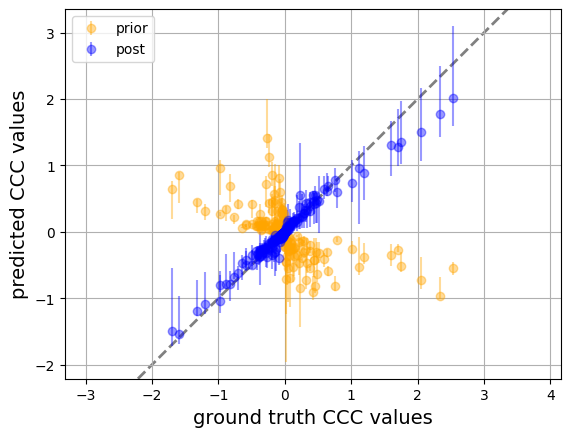

In [32]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC_noReg.melt()['value'], priorCCC_noReg_meds['median'], yerr=CCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], yerr=CCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs_noReg.svg', format="svg")

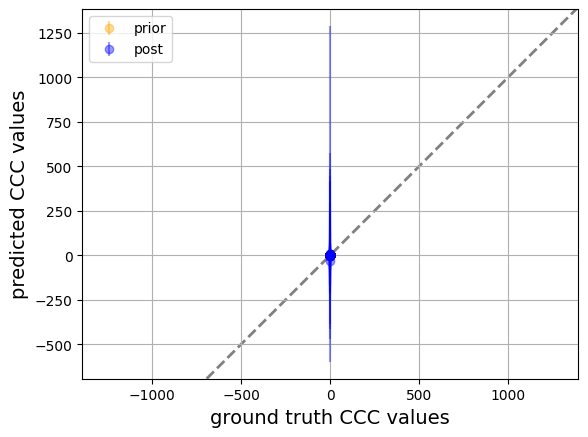

In [33]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC_reg1.melt()['value'], priorCCC_reg1_meds['median'], yerr=CCC_errors_reg1_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], yerr=CCC_errors_reg1_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs_reg1.svg', format="svg")

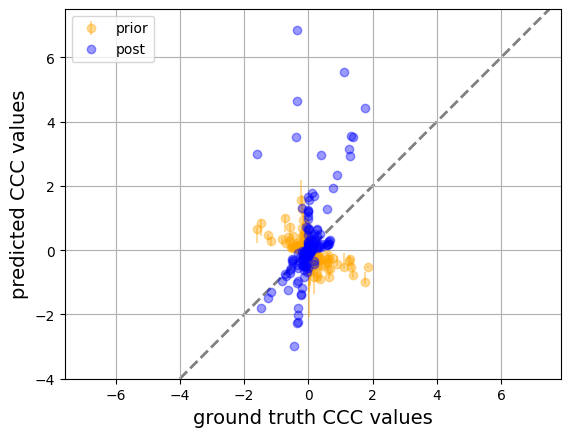

In [40]:
plt.axes().set_aspect('equal', 'datalim')

plt.ylim(-4, 7.5)

plt.errorbar(gtCCC_reg1.melt()['value'], priorCCC_reg1_meds['median'], yerr=CCC_errors_reg1_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b') # yerr=CCC_errors_reg1_post

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs_reg1_zoom.svg', format="svg")

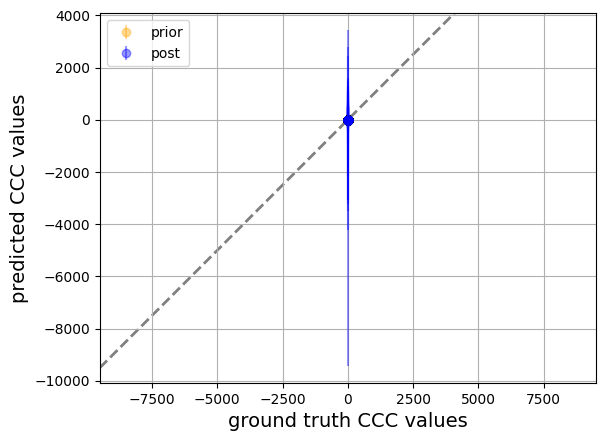

In [46]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC_reg2.melt()['value'], priorCCC_reg2_meds['median'], yerr=CCC_errors_reg2_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], yerr=CCC_errors_reg2_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs_reg2.svg', format="svg")

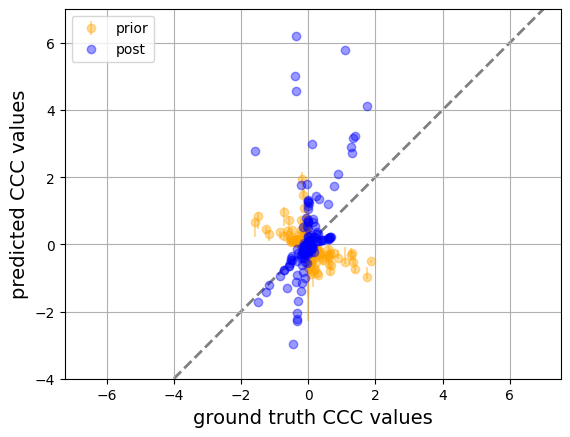

In [45]:
plt.axes().set_aspect('equal', 'datalim')

plt.ylim((-4,7))

plt.errorbar(gtCCC_reg2.melt()['value'], priorCCC_reg2_meds['median'], yerr=CCC_errors_reg2_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b') # yerr=CCC_errors_reg2_post,

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs_reg2_zoom.svg', format="svg")

### combined graph of CCC values

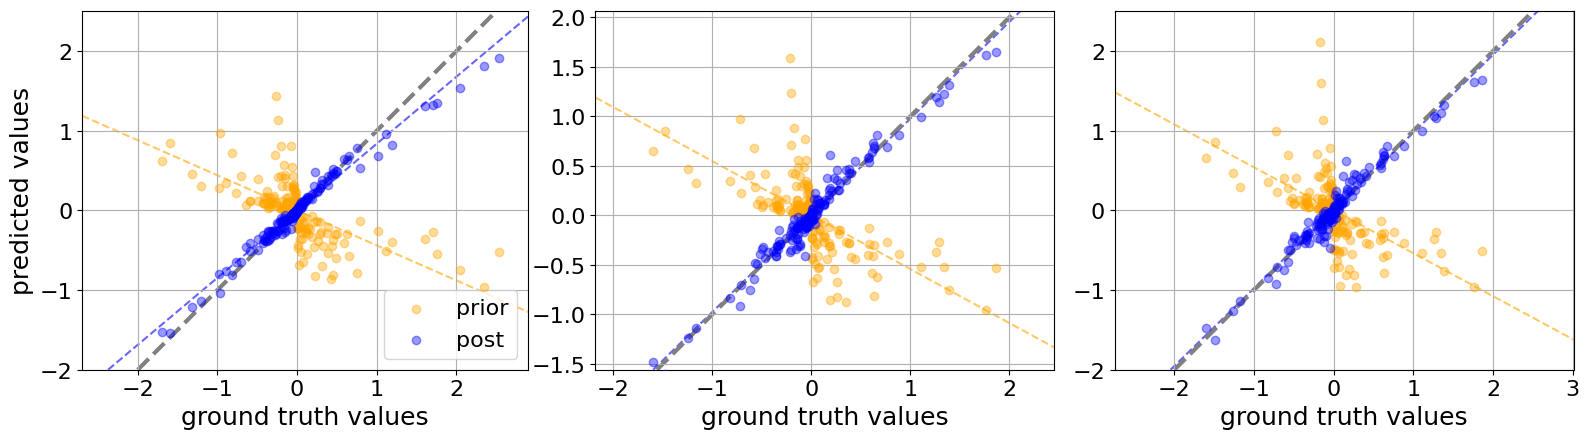

In [27]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(1, 3, figsize=(16,4.5))

for ii in range(3):
    ax[ii].tick_params(axis='both', which='major', labelsize=16)

ax[0].set_aspect('equal')
ax[0].scatter(gtCCC_noReg.melt()['value'], priorCCC_noReg_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0].scatter(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], alpha=0.4, label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], priorCCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].set_xlim((-2.7,2.9))
ax[0].set_ylim((-2,2.5))
ax[0].grid()
ax[0].legend(loc="lower right", fontsize=16)
ax[0].set_xlabel('ground truth values', fontsize=18)

ax[1].set_aspect('equal', 'datalim')
ax[1].scatter(gtCCC_reg1.melt()['value'], priorCCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1].scatter(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], priorCCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
# ax[1].set_ylim((-4,8))
ax[1].set_ylim((-2,2.5))
ax[1].grid()
ax[1].set_xlabel('ground truth values', fontsize=18)

ax[2].set_aspect('equal', 'datalim')
ax[2].scatter(gtCCC_reg2.melt()['value'], priorCCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[2].scatter(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], priorCCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
#ax[2].set_ylim((-4,8))
ax[2].set_ylim((-2,2.5))
ax[2].grid()

ax[2].set_xlabel('ground truth values', fontsize=18)
ax[0].set_ylabel('predicted values', fontsize=18)
  
f.tight_layout()

# plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedCCCs.svg', format="svg")

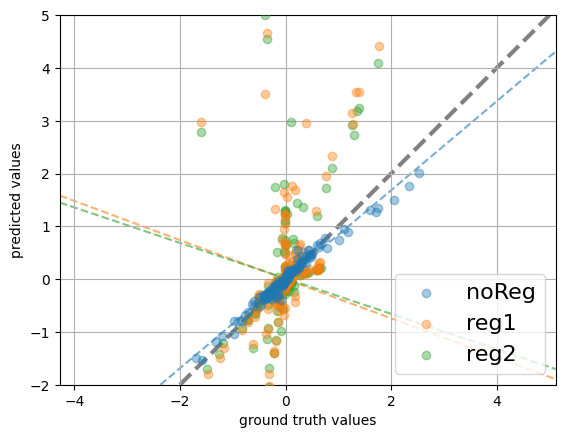

In [77]:
# Create two subplots and unpack the output array immediately

plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], alpha=0.4, label='noReg', zorder=300)
plt.scatter(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], alpha=0.4,  label='reg1', zorder=200)
plt.scatter(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], alpha=0.4,  label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="lower right", fontsize=16)

plt.xlabel('ground truth values')
plt.ylabel('predicted values')

plt.ylim((-2, 5))

f.tight_layout()

# plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedCCCs_byAllostery.svg', format="svg")

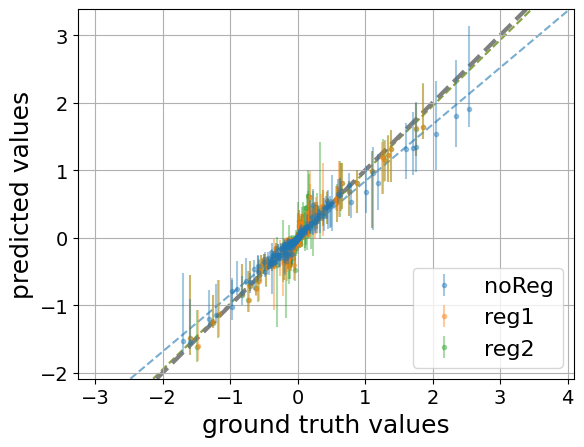

In [28]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'], yerr=CCC_errors_noReg_post, alpha=0.4, fmt='o', markersize=3, label='noReg', zorder=300)
plt.errorbar(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'], yerr=CCC_errors_reg1_post, alpha=0.4, fmt='o', markersize=3, label='reg1', zorder=200)
plt.errorbar(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'], yerr=CCC_errors_reg2_post, alpha=0.4, fmt='o', markersize=3, label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtCCC_noReg.melt()['value'], postCCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg1.melt()['value'], postCCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtCCC_reg2.melt()['value'], postCCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="lower right", fontsize=16)

plt.xlabel('ground truth values', fontsize=18)
plt.ylabel('predicted values', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedCCCs_byAllostery_wError.svg', format="svg")

## Calculating FCC values and making graphs

In [29]:
gtFCC_noReg = pd.DataFrame(rr_noReg.getScaledFluxControlCoefficientMatrix(), index=rr_noReg.getReactionIds(), columns=rr_noReg.getReactionIds())
gtFCC_reg1 = pd.DataFrame(rr_reg1.getScaledFluxControlCoefficientMatrix(), index=rr_noReg.getReactionIds(), columns=rr_noReg.getReactionIds())
gtFCC_reg2 = pd.DataFrame(rr_reg2.getScaledFluxControlCoefficientMatrix(), index=rr_noReg.getReactionIds(), columns=rr_noReg.getReactionIds())

### priors

In [30]:
Ex01_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_noReg)['prior']['Ex'])
Ex02_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_noReg)['prior']['Ex'])
Ex03_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_noReg)['prior']['Ex'])
Ex04_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_noReg)['prior']['Ex'])
Ex05_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_noReg)['prior']['Ex'])
Ex15_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_noReg)['prior']['Ex'])
Ex3_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_noReg)['prior']['Ex'])
Ex5_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_noReg)['prior']['Ex'])
Ex7_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_noReg)['prior']['Ex'])
Ex100_prior_noReg= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_noReg)['prior']['Ex'])

Ex01_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_reg1)['prior']['Ex'])
Ex02_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_reg1)['prior']['Ex'])
Ex03_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_reg1)['prior']['Ex'])
Ex04_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_reg1)['prior']['Ex'])
Ex05_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_reg1)['prior']['Ex'])
Ex15_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_reg1)['prior']['Ex'])
Ex3_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_reg1)['prior']['Ex'])
Ex5_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_reg1)['prior']['Ex'])
Ex7_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_reg1)['prior']['Ex'])
Ex100_prior_reg1= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_reg1)['prior']['Ex'])

Ex01_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj01_reg2)['prior']['Ex'])
Ex02_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj02_reg2)['prior']['Ex'])
Ex03_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj03_reg2)['prior']['Ex'])
Ex04_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj04_reg2)['prior']['Ex'])
Ex05_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj05_reg2)['prior']['Ex'])
Ex15_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj15_reg2)['prior']['Ex'])
Ex3_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj3_reg2)['prior']['Ex'])
Ex5_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj5_reg2)['prior']['Ex'])
Ex7_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj7_reg2)['prior']['Ex'])
Ex100_prior_reg2= util.get_az_summary(util.run_prior_predictive(BMCA_obj100_reg2)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

In [31]:
priorFCC01_noReg = util.estimate_FCCs(BMCA_obj01_noReg, Ex01_prior_noReg.reshape((19,13)))
priorFCC02_noReg = util.estimate_FCCs(BMCA_obj02_noReg, Ex02_prior_noReg.reshape((19,13)))
priorFCC03_noReg = util.estimate_FCCs(BMCA_obj03_noReg, Ex03_prior_noReg.reshape((19,13)))
priorFCC04_noReg = util.estimate_FCCs(BMCA_obj04_noReg, Ex04_prior_noReg.reshape((19,13)))
priorFCC05_noReg = util.estimate_FCCs(BMCA_obj05_noReg, Ex05_prior_noReg.reshape((19,13)))
priorFCC15_noReg = util.estimate_FCCs(BMCA_obj15_noReg, Ex15_prior_noReg.reshape((19,13)))
priorFCC3_noReg = util.estimate_FCCs(BMCA_obj3_noReg, Ex3_prior_noReg.reshape((19,13)))
priorFCC5_noReg = util.estimate_FCCs(BMCA_obj5_noReg, Ex5_prior_noReg.reshape((19,13)))
priorFCC7_noReg = util.estimate_FCCs(BMCA_obj7_noReg, Ex7_prior_noReg.reshape((19,13)))
priorFCC100_noReg = util.estimate_FCCs(BMCA_obj100_noReg, Ex100_prior_noReg.reshape((19,13)))

priorFCC01_reg1 = util.estimate_FCCs(BMCA_obj01_reg1, Ex01_prior_reg1.reshape((19,13)))
priorFCC02_reg1 = util.estimate_FCCs(BMCA_obj02_reg1, Ex02_prior_reg1.reshape((19,13)))
priorFCC03_reg1 = util.estimate_FCCs(BMCA_obj03_reg1, Ex03_prior_reg1.reshape((19,13)))
priorFCC04_reg1 = util.estimate_FCCs(BMCA_obj04_reg1, Ex04_prior_reg1.reshape((19,13)))
priorFCC05_reg1 = util.estimate_FCCs(BMCA_obj05_reg1, Ex05_prior_reg1.reshape((19,13)))
priorFCC15_reg1 = util.estimate_FCCs(BMCA_obj15_reg1, Ex15_prior_reg1.reshape((19,13)))
priorFCC3_reg1 = util.estimate_FCCs(BMCA_obj3_reg1, Ex3_prior_reg1.reshape((19,13)))
priorFCC5_reg1 = util.estimate_FCCs(BMCA_obj5_reg1, Ex5_prior_reg1.reshape((19,13)))
priorFCC7_reg1 = util.estimate_FCCs(BMCA_obj7_reg1, Ex7_prior_reg1.reshape((19,13)))
priorFCC100_reg1 = util.estimate_FCCs(BMCA_obj100_reg1, Ex100_prior_reg1.reshape((19,13)))

priorFCC01_reg2 = util.estimate_FCCs(BMCA_obj01_reg2, Ex01_prior_reg2.reshape((19,13)))
priorFCC02_reg2 = util.estimate_FCCs(BMCA_obj02_reg2, Ex02_prior_reg2.reshape((19,13)))
priorFCC03_reg2 = util.estimate_FCCs(BMCA_obj03_reg2, Ex03_prior_reg2.reshape((19,13)))
priorFCC04_reg2 = util.estimate_FCCs(BMCA_obj04_reg2, Ex04_prior_reg2.reshape((19,13)))
priorFCC05_reg2 = util.estimate_FCCs(BMCA_obj05_reg2, Ex05_prior_reg2.reshape((19,13)))
priorFCC15_reg2 = util.estimate_FCCs(BMCA_obj15_reg2, Ex15_prior_reg2.reshape((19,13)))
priorFCC3_reg2 = util.estimate_FCCs(BMCA_obj3_reg2, Ex3_prior_reg2.reshape((19,13)))
priorFCC5_reg2 = util.estimate_FCCs(BMCA_obj5_reg2, Ex5_prior_reg2.reshape((19,13)))
priorFCC7_reg2 = util.estimate_FCCs(BMCA_obj7_reg2, Ex7_prior_reg2.reshape((19,13)))
priorFCC100_reg2 = util.estimate_FCCs(BMCA_obj100_reg2, Ex100_prior_reg2.reshape((19,13)))


In [32]:
priorFCCs_noReg = [priorFCC01_noReg, priorFCC02_noReg, priorFCC03_noReg, priorFCC04_noReg, priorFCC05_noReg, priorFCC15_noReg, priorFCC3_noReg, priorFCC5_noReg, priorFCC7_noReg, priorFCC100_noReg]
priorFCCs_reg1 = [priorFCC01_reg1, priorFCC02_reg1, priorFCC03_reg1, priorFCC04_reg1, priorFCC05_reg1, priorFCC15_reg1, priorFCC3_reg1, priorFCC5_reg1, priorFCC7_reg1, priorFCC100_reg1]
priorFCCs_reg2 = [priorFCC01_reg2, priorFCC02_reg2, priorFCC03_reg2, priorFCC04_reg2, priorFCC05_reg2, priorFCC15_reg2, priorFCC3_reg2, priorFCC5_reg2, priorFCC7_reg2, priorFCC100_reg2]

In [33]:
priorFCC_noReg_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getReactionIds()) for priorFCC in priorFCCs_noReg]
priorFCC_noReg_meds = pd.concat([i.melt()['value'] for i in priorFCC_noReg_meds], axis=1).values
priorFCC_noReg_meds = pd.DataFrame(priorFCC_noReg_meds, columns=pt_labels)
priorFCC_noReg_meds['median'] = priorFCC_noReg_meds.median(axis=1)
priorFCC_noReg_meds['min'] = priorFCC_noReg_meds.min(axis=1)
priorFCC_noReg_meds['max'] = priorFCC_noReg_meds.max(axis=1)
# priorFCC_noReg_meds

In [34]:
priorFCC_reg1_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getReactionIds()) for priorFCC in priorFCCs_reg1]
priorFCC_reg1_meds = pd.concat([i.melt()['value'] for i in priorFCC_reg1_meds], axis=1).values
priorFCC_reg1_meds = pd.DataFrame(priorFCC_reg1_meds, columns=pt_labels)
priorFCC_reg1_meds['median'] = priorFCC_reg1_meds.median(axis=1)
priorFCC_reg1_meds['min'] = priorFCC_reg1_meds.min(axis=1)
priorFCC_reg1_meds['max'] = priorFCC_reg1_meds.max(axis=1)
# priorFCC_reg1_meds

In [35]:
priorFCC_reg2_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getReactionIds()) for priorFCC in priorFCCs_reg2]
priorFCC_reg2_meds = pd.concat([i.melt()['value'] for i in priorFCC_reg2_meds], axis=1).values
priorFCC_reg2_meds = pd.DataFrame(priorFCC_reg2_meds, columns=pt_labels)
priorFCC_reg2_meds['median'] = priorFCC_reg2_meds.median(axis=1)
priorFCC_reg2_meds['min'] = priorFCC_reg2_meds.min(axis=1)
priorFCC_reg2_meds['max'] = priorFCC_reg2_meds.max(axis=1)
# priorFCC_reg2_meds

In [36]:
FCC_lower_y_noReg_prior = np.array(priorFCC_noReg_meds['median']) - np.array(priorFCC_noReg_meds['min'])
FCC_upper_y_noReg_prior = np.array(priorFCC_noReg_meds['max']) - np.array(priorFCC_noReg_meds['median'])
FCC_errors_noReg_prior = [FCC_lower_y_noReg_prior, FCC_upper_y_noReg_prior]

FCC_lower_y_reg1_prior = np.array(priorFCC_reg1_meds['median']) - np.array(priorFCC_reg1_meds['min'])
FCC_upper_y_reg1_prior = np.array(priorFCC_reg1_meds['max']) - np.array(priorFCC_reg1_meds['median'])
FCC_errors_reg1_prior = [FCC_lower_y_reg1_prior, FCC_upper_y_reg1_prior]

FCC_lower_y_reg2_prior = np.array(priorFCC_reg2_meds['median']) - np.array(priorFCC_reg2_meds['min'])
FCC_upper_y_reg2_prior = np.array(priorFCC_reg2_meds['max']) - np.array(priorFCC_reg2_meds['median'])
FCC_errors_reg2_prior = [FCC_lower_y_reg2_prior, FCC_upper_y_reg2_prior]

### posteriors

In [37]:
# all data
postFCC01_noReg = util.estimate_FCCs(BMCA_obj01_noReg, Ex01_noReg.reshape((19,13)))
postFCC02_noReg = util.estimate_FCCs(BMCA_obj02_noReg, Ex02_noReg.reshape((19,13)))
postFCC03_noReg = util.estimate_FCCs(BMCA_obj03_noReg, Ex03_noReg.reshape((19,13)))
postFCC04_noReg = util.estimate_FCCs(BMCA_obj04_noReg, Ex04_noReg.reshape((19,13)))
postFCC05_noReg = util.estimate_FCCs(BMCA_obj05_noReg, Ex05_noReg.reshape((19,13)))
postFCC15_noReg = util.estimate_FCCs(BMCA_obj15_noReg, Ex15_noReg.reshape((19,13)))
postFCC3_noReg = util.estimate_FCCs(BMCA_obj3_noReg, Ex3_noReg.reshape((19,13)))
postFCC5_noReg = util.estimate_FCCs(BMCA_obj5_noReg, Ex5_noReg.reshape((19,13)))
postFCC7_noReg = util.estimate_FCCs(BMCA_obj7_noReg, Ex7_noReg.reshape((19,13)))
postFCC100_noReg = util.estimate_FCCs(BMCA_obj100_noReg, Ex100_noReg.reshape((19,13)))

postFCC01_reg1 = util.estimate_FCCs(BMCA_obj01_reg1, Ex01_reg1.reshape((19,13)))
postFCC02_reg1 = util.estimate_FCCs(BMCA_obj02_reg1, Ex02_reg1.reshape((19,13)))
postFCC03_reg1 = util.estimate_FCCs(BMCA_obj03_reg1, Ex03_reg1.reshape((19,13)))
postFCC04_reg1 = util.estimate_FCCs(BMCA_obj04_reg1, Ex04_reg1.reshape((19,13)))
postFCC05_reg1 = util.estimate_FCCs(BMCA_obj05_reg1, Ex05_reg1.reshape((19,13)))
postFCC15_reg1 = util.estimate_FCCs(BMCA_obj15_reg1, Ex15_reg1.reshape((19,13)))
postFCC3_reg1 = util.estimate_FCCs(BMCA_obj3_reg1, Ex3_reg1.reshape((19,13)))
postFCC5_reg1 = util.estimate_FCCs(BMCA_obj5_reg1, Ex5_reg1.reshape((19,13)))
postFCC7_reg1 = util.estimate_FCCs(BMCA_obj7_reg1, Ex7_reg1.reshape((19,13)))
postFCC100_reg1 = util.estimate_FCCs(BMCA_obj100_reg1, Ex100_reg1.reshape((19,13)))

postFCC01_reg2 = util.estimate_FCCs(BMCA_obj01_reg2, Ex01_reg2.reshape((19,13)))
postFCC02_reg2 = util.estimate_FCCs(BMCA_obj02_reg2, Ex02_reg2.reshape((19,13)))
postFCC03_reg2 = util.estimate_FCCs(BMCA_obj03_reg2, Ex03_reg2.reshape((19,13)))
postFCC04_reg2 = util.estimate_FCCs(BMCA_obj04_reg2, Ex04_reg2.reshape((19,13)))
postFCC05_reg2 = util.estimate_FCCs(BMCA_obj05_reg2, Ex05_reg2.reshape((19,13)))
postFCC15_reg2 = util.estimate_FCCs(BMCA_obj15_reg2, Ex15_reg2.reshape((19,13)))
postFCC3_reg2 = util.estimate_FCCs(BMCA_obj3_reg2, Ex3_reg2.reshape((19,13)))
postFCC5_reg2 = util.estimate_FCCs(BMCA_obj5_reg2, Ex5_reg2.reshape((19,13)))
postFCC7_reg2 = util.estimate_FCCs(BMCA_obj7_reg2, Ex7_reg2.reshape((19,13)))
postFCC100_reg2 = util.estimate_FCCs(BMCA_obj100_reg2, Ex100_reg2.reshape((19,13)))

In [38]:
postFCCs_noReg = [postFCC01_noReg, postFCC02_noReg, postFCC03_noReg, postFCC04_noReg, postFCC05_noReg, postFCC15_noReg, postFCC3_noReg, postFCC5_noReg, postFCC7_noReg, postFCC100_noReg]
postFCCs_reg1 = [postFCC01_reg1, postFCC02_reg1, postFCC03_reg1, postFCC04_reg1, postFCC05_reg1, postFCC15_reg1, postFCC3_reg1, postFCC5_reg1, postFCC7_reg1, postFCC100_reg1]
postFCCs_reg2 = [postFCC01_reg2, postFCC02_reg2, postFCC03_reg2, postFCC04_reg2, postFCC05_reg2, postFCC15_reg2, postFCC3_reg2, postFCC5_reg2, postFCC7_reg2, postFCC100_reg2]

In [39]:
postFCC_noReg_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=rr_noReg.getReactionIds(), index=rr_noReg.getReactionIds()) for postFCC in postFCCs_noReg]
postFCC_noReg_meds = pd.concat([i.melt()['value'] for i in postFCC_noReg_meds], axis=1).values
postFCC_noReg_meds = pd.DataFrame(postFCC_noReg_meds, columns=pt_labels)
postFCC_noReg_meds['median'] = postFCC_noReg_meds.median(axis=1)
postFCC_noReg_meds['min'] = postFCC_noReg_meds.min(axis=1)
postFCC_noReg_meds['max'] = postFCC_noReg_meds.max(axis=1)
# postFCC_noReg_meds

In [40]:
postFCC_reg1_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=rr_reg1.getReactionIds(), index=rr_reg1.getReactionIds()) for postFCC in postFCCs_reg1]
postFCC_reg1_meds = pd.concat([i.melt()['value'] for i in postFCC_reg1_meds], axis=1).values
postFCC_reg1_meds = pd.DataFrame(postFCC_reg1_meds, columns=pt_labels)
postFCC_reg1_meds['median'] = postFCC_reg1_meds.median(axis=1)
postFCC_reg1_meds['min'] = postFCC_reg1_meds.min(axis=1)
postFCC_reg1_meds['max'] = postFCC_reg1_meds.max(axis=1)
# postFCC_reg1_meds

In [41]:
postFCC_reg2_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=rr_reg2.getReactionIds(), index=rr_reg2.getReactionIds()) for postFCC in postFCCs_reg2]
postFCC_reg2_meds = pd.concat([i.melt()['value'] for i in postFCC_reg2_meds], axis=1).values
postFCC_reg2_meds = pd.DataFrame(postFCC_reg2_meds, columns=pt_labels)
postFCC_reg2_meds['median'] = postFCC_reg2_meds.median(axis=1)
postFCC_reg2_meds['min'] = postFCC_reg2_meds.min(axis=1)
postFCC_reg2_meds['max'] = postFCC_reg2_meds.max(axis=1)
# postFCC_reg2_meds

In [42]:
FCC_lower_y_noReg_post = np.array(postFCC_noReg_meds['median']) - np.array(postFCC_noReg_meds['min'])
FCC_upper_y_noReg_post = np.array(postFCC_noReg_meds['max']) - np.array(postFCC_noReg_meds['median'])
FCC_errors_noReg_post = [FCC_lower_y_noReg_post, FCC_upper_y_noReg_post]

FCC_lower_y_reg1_post = np.array(postFCC_reg1_meds['median']) - np.array(postFCC_reg1_meds['min'])
FCC_upper_y_reg1_post = np.array(postFCC_reg1_meds['max']) - np.array(postFCC_reg1_meds['median'])
FCC_errors_reg1_post = [FCC_lower_y_reg1_post, FCC_upper_y_reg1_post]

FCC_lower_y_reg2_post = np.array(postFCC_reg2_meds['median']) - np.array(postFCC_reg2_meds['min'])
FCC_upper_y_reg2_post = np.array(postFCC_reg2_meds['max']) - np.array(postFCC_reg2_meds['median'])
FCC_errors_reg2_post = [FCC_lower_y_reg2_post, FCC_upper_y_reg2_post]

### graphs

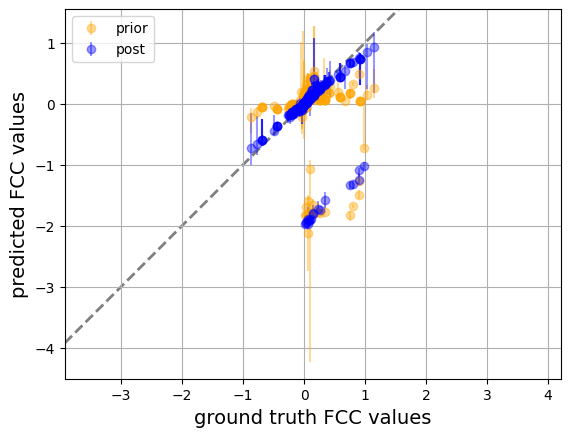

In [40]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], yerr=FCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_noReg.svg', format="svg")

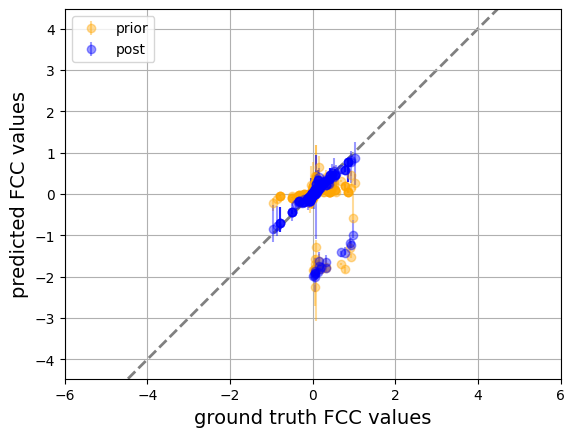

In [41]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], yerr=FCC_errors_reg1_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], yerr=FCC_errors_reg1_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')
plt.xlim((-6,6))
plt.ylim((-6,6))
plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)

plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_reg1.svg', format="svg")

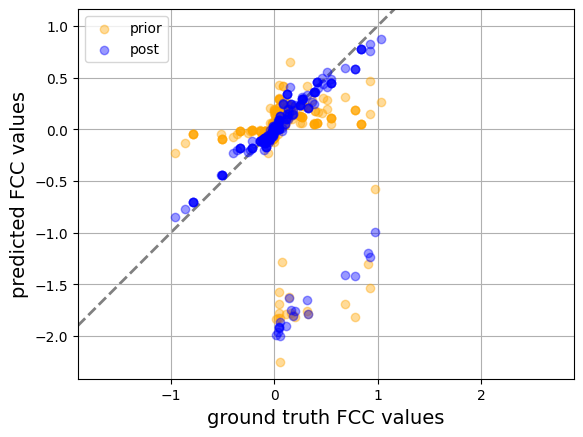

In [43]:
## needs to be rerun

plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
plt.scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
plt.xlim((-6,7))
plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)

plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_reg1.svg', format="svg")

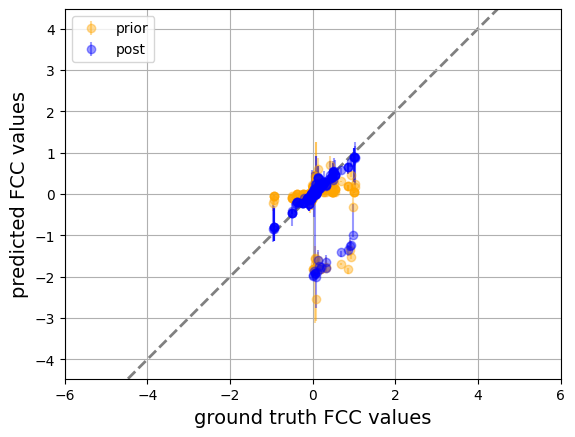

In [45]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], yerr=FCC_errors_reg2_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], yerr=FCC_errors_reg2_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')
plt.xlim((-6,6))
plt.ylim((-6,6))
plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_reg2.svg', format="svg")

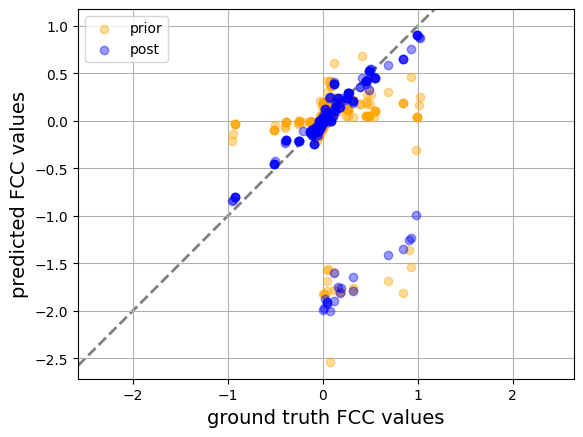

In [48]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
plt.scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4, label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_reg2.svg', format="svg")

### adding corrections for where the enzyme perturbed is directly involved in the reaction

In [43]:
rxn = np.repeat(rr_noReg.getReactionIds(),len(rr_noReg.getReactionIds()))
enz_pt = rr_noReg.getReactionIds() * len(rr_noReg.getReactionIds())
FCC_idx = pd.DataFrame([rxn, enz_pt]).T

In [44]:
for i in np.where(abs(gtFCC_noReg.melt()['value']- postFCC_noReg_meds['median'])>1):
    print(FCC_idx.iloc[i])
pt_enz_is_rxn = list(np.where(abs(gtFCC_noReg.melt()['value']- postFCC_noReg_meds['median'])>1)[0])

       0    1
0     v1   v1
20    v2   v2
40    v3   v3
60    v4   v4
80    v5   v5
100   v6   v6
120   v7   v7
140   v8   v8
160   v9   v9
180  v10  v10
200  v11  v11
220  v12  v12
240  v13  v13
260  v14  v14
280  v15  v15
300  v16  v16
320  v17  v17
340  v18  v18
360  v19  v19


### graphing the corrected FCC dfs

In [32]:
priorFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2

NameError: name 'pt_enz_is_rxn' is not defined

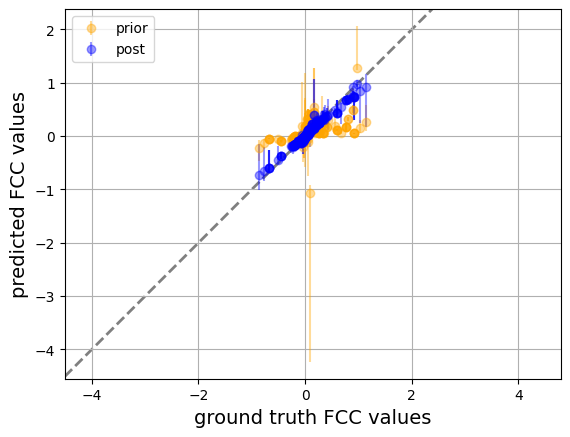

In [53]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], yerr=FCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_noReg_wCorrection.svg', format="svg")

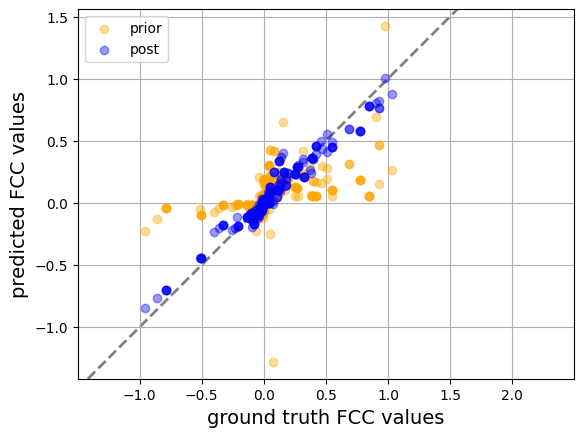

In [55]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
plt.scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
plt.xlim((-6,7))

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_reg1_wCorrection.svg', format="svg")

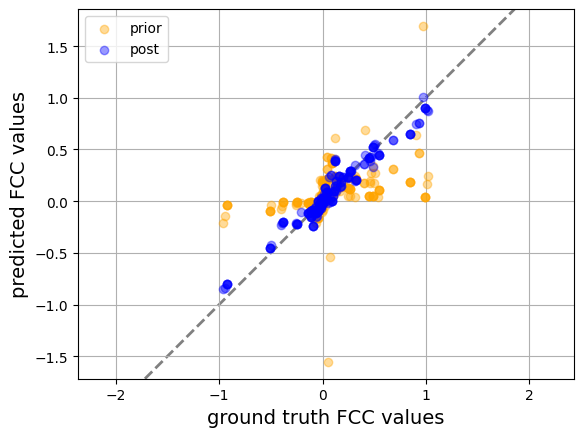

In [57]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
plt.scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4, label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_reg2_wCorrection.svg', format="svg")

### Combined graph of FCC values

In [ ]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(2, 3, figsize=(16,8))

for i in range(2):
    for ii in range(3):
        ax[i,ii].tick_params(axis='both', which='major', labelsize=16)

ax[0,0].set_aspect('equal', 'datalim')
ax[0,0].scatter(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0,0].scatter(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'])
ax[0,0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
ax[0,0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0,0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0,0].grid()
ax[0,0].legend(loc="lower right", fontsize=16)

ax[0,1].set_aspect('equal', 'datalim')
ax[0,1].scatter(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0,1].scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'])
ax[0,1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
ax[0,1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0,1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0,1].grid()

ax[0,2].set_aspect('equal', 'datalim')
ax[0,2].scatter(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0,2].scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'])
ax[0,2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
ax[0,2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0,2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0,2].grid()

priorFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2

ax[1,0].set_aspect('equal', 'datalim')
ax[1,0].scatter(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1,0].scatter(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'])
ax[1,0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
ax[1,0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1,0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1,0].grid()

ax[1,1].set_aspect('equal', 'datalim')
ax[1,1].scatter(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1,1].scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'])
ax[1,1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
ax[1,1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1,1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1,1].grid()

ax[1,2].set_aspect('equal', 'datalim')
ax[1,2].scatter(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1,2].scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'])
ax[1,2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
ax[1,2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1,2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1,2].grid()
    
f.tight_layout()

plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-combinedFCCs.svg', format="svg")

In [45]:
priorFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg1_meds.loc[pt_enz_is_rxn, 'median'] += 2

priorFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_reg2_meds.loc[pt_enz_is_rxn, 'median'] += 2

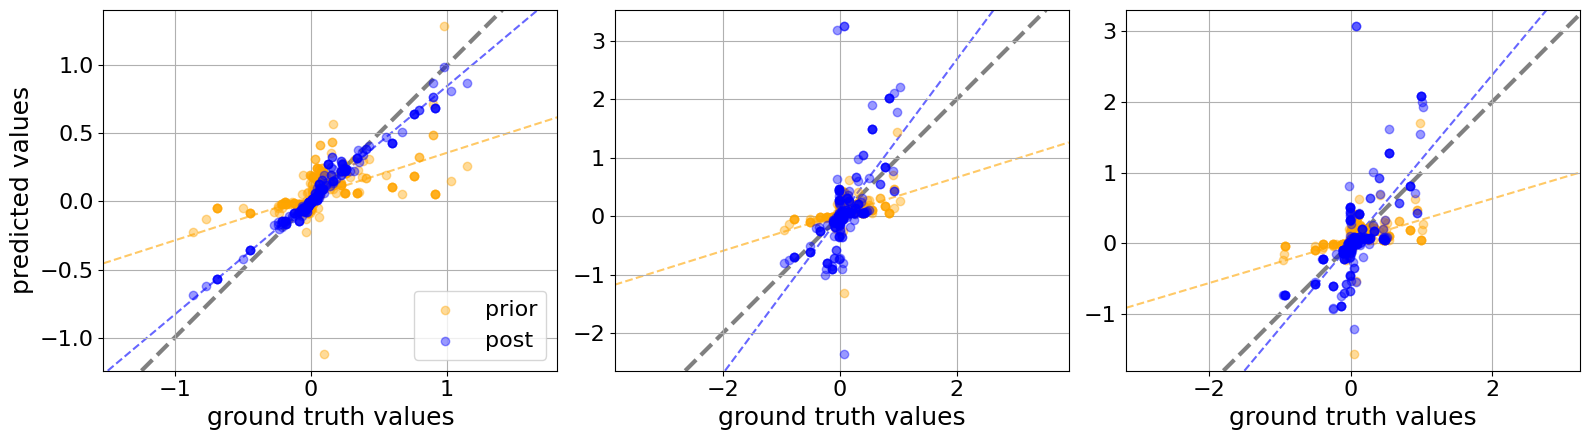

In [55]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(1, 3, figsize=(16,4.5))

for ii in range(3):
    ax[ii].tick_params(axis='both', which='major', labelsize=16)

ax[0].set_aspect('equal', 'datalim')
ax[0].scatter(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[0].scatter(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], priorFCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
ax[0].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].grid()
ax[0].legend(loc="lower right", fontsize=16)
ax[0].set_xlabel('ground truth values', fontsize=18)

ax[1].set_aspect('equal', 'datalim')
ax[1].scatter(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[1].scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], priorFCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
ax[1].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1].grid()
ax[1].set_xlabel('ground truth values', fontsize=18)

ax[2].set_aspect('equal', 'datalim')
ax[2].scatter(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'], alpha=0.4, label='prior', zorder=100, c='orange')
ax[2].scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4,  label='post', zorder=100, c='b')
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], priorFCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='orange', zorder=0)
slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
ax[2].axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='b', zorder=0)
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[2].grid()

ax[2].set_xlabel('ground truth values', fontsize=18)
ax[0].set_ylabel('predicted values', fontsize=18)

f.tight_layout()

plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedFCCs.svg', format="svg")

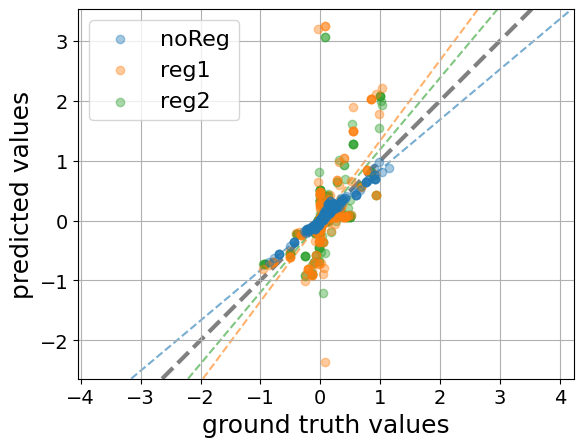

In [56]:
# Create two subplots and unpack the output array immediately

plt.axes().set_aspect('equal', 'datalim')

plt.scatter(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, label='noReg', zorder=300)
plt.scatter(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], alpha=0.4,  label='reg1', zorder=200)
plt.scatter(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], alpha=0.4,  label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="upper left", fontsize=16)

plt.xlabel('ground truth values', fontsize=18)
plt.ylabel('predicted values', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

f.tight_layout()

plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedFCCs_byAllostery.svg', format="svg")

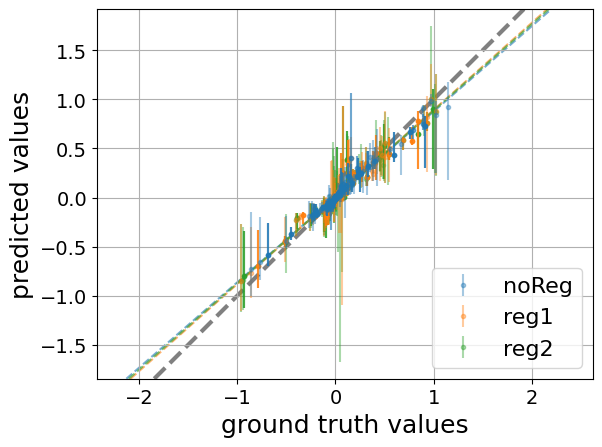

In [46]:
# fruit

plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', markersize=3, label='noReg', zorder=300)
plt.errorbar(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'], yerr=FCC_errors_reg1_post, alpha=0.4, fmt='o', markersize=3, label='reg1', zorder=200)
plt.errorbar(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'], yerr=FCC_errors_reg2_post, alpha=0.4, fmt='o', markersize=3, label='reg2', zorder=100)

slope, intercept, _ = util.calculate_slope(gtFCC_noReg.melt()['value'], postFCC_noReg_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:blue', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg1.melt()['value'], postFCC_reg1_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:orange', zorder=0)

slope, intercept, _ = util.calculate_slope(gtFCC_reg2.melt()['value'], postFCC_reg2_meds['median'])
plt.axline((0, intercept), slope=slope, linestyle='--', alpha=0.6, color='tab:green', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid()
plt.legend(loc="lower right", fontsize=16)

plt.xlabel('ground truth values', fontsize=18)
plt.ylabel('predicted values', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#f.tight_layout()

plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-combinedFCCs_byAllostery_wError.svg', format="svg")

### Graphing the absolute error

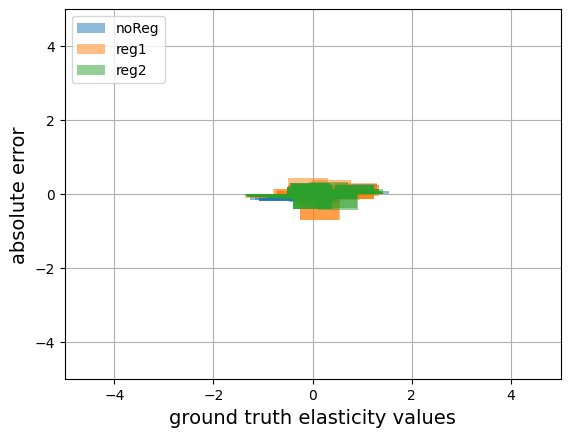

In [39]:
# FCCs need to be corrected before running this cell

plt.grid()
plt.xlim((-5,5))
plt.ylim((-5,5))

plt.bar(gtFCC_noReg.melt()['value'], gtFCC_noReg.melt()['value']-postFCC_noReg_meds['median'], alpha=0.5, label='noReg', zorder=200)
plt.bar(gtFCC_reg1.melt()['value'], gtFCC_reg1.melt()['value']-postFCC_reg1_meds['median'], alpha=0.5, label='reg1', zorder=200)
plt.bar(gtFCC_reg2.melt()['value'], gtFCC_reg2.melt()['value']-postFCC_reg2_meds['median'], alpha=0.5, label='reg2', zorder=200)

plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('absolute error', size=14)

plt.legend(loc="upper left")
plt.savefig(f'../data/results/raw_svg_figures/top{topology}/top{topology}-{omission}-absError_byAllostery.svg', format="svg")

### Comparing elasticity values with FCC values. 


In [28]:
ela_noReg_df

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x,median,min,max
0,0.012,0.006,0.010,0.003,-0.005,-0.003,0.009,-0.008,0.005,0.004,0.0045,-0.008,0.012
1,-0.338,-0.306,-0.239,-0.232,-0.208,-0.336,-0.403,-0.436,-0.437,-0.442,-0.3370,-0.442,-0.208
2,-0.015,0.005,0.008,0.000,0.004,0.001,-0.002,0.006,0.009,-0.004,0.0025,-0.015,0.009
3,0.006,-0.004,0.010,-0.003,0.007,0.004,0.008,-0.001,0.004,0.005,0.0045,-0.004,0.010
4,0.008,0.010,0.006,-0.003,0.006,-0.001,0.003,0.000,0.006,0.000,0.0045,-0.003,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,-0.004,-0.005,-0.001,0.000,0.006,0.000,0.000,0.006,0.009,0.004,0.0000,-0.005,0.009
243,-0.006,-0.005,-0.005,-0.001,-0.006,0.002,0.002,0.008,-0.005,0.005,-0.0030,-0.006,0.008
244,-0.020,-0.011,-0.011,-0.004,-0.007,-0.009,-0.013,-0.017,-0.040,-0.095,-0.0120,-0.095,-0.004
245,0.004,-0.003,0.006,-0.003,-0.007,0.002,-0.004,0.013,0.000,0.001,0.0005,-0.007,0.013


In [30]:
postFCC_noReg_meds

,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x,median,min,max
0,-1.452365,-1.504568,-1.459433,-1.539324,-1.528220,-1.699724,-1.704990,-1.719983,-1.704306,-1.718776,-1.619524,-1.719983,-1.452365
1,0.980925,0.703016,0.692264,0.446629,0.411264,0.143485,0.201340,0.208049,0.225773,0.244899,0.328082,0.143485,0.980925
2,0.980925,0.703016,0.692264,0.446629,0.411264,0.143485,0.201340,0.208049,0.225773,0.244899,0.328082,0.143485,0.980925
3,0.419860,0.434212,0.495829,0.464819,0.489628,0.346517,0.322635,0.301242,0.316315,0.291937,0.383188,0.291937,0.495829
4,0.419860,0.434212,0.495829,0.464819,0.489628,0.346517,0.322635,0.301242,0.316315,0.291937,0.383188,0.291937,0.495829
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.012204,-0.006490,-0.002531,-0.002283,-0.002511,-0.001045,-0.002450,-0.003086,-0.005191,-0.006964,-0.002808,-0.012204,-0.001045
357,-0.012204,-0.006490,-0.002531,-0.002283,-0.002511,-0.001045,-0.002450,-0.003086,-0.005191,-0.006964,-0.002808,-0.012204,-0.001045
358,-0.012204,-0.006490,-0.002531,-0.002283,-0.002511,-0.001045,-0.002450,-0.003086,-0.005191,-0.006964,-0.002808,-0.012204,-0.001045
359,0.210061,0.238124,0.248757,0.253647,0.260030,0.274622,0.250842,0.246343,0.243389,0.241421,0.247550,0.210061,0.274622


## How does the presence of regulators affect BMCA’s performance?

### Classic ANOVA across different regulation
Tells you whether the group means are same/different

In [29]:
def calculate_anova(*args):
    return round(sp.stats.f_oneway(*args)[0],3), round(sp.stats.f_oneway(*args)[1],3)

def make_anova_table(pt_labels, list_of_args):
    f_list = []
    p_list = []
    
    for i in list_of_args:
        f, p = calculate_anova(*i)
        f_list.append(f)
        p_list.append(p)
    
    anova_table = pd.DataFrame(list(zip(f_list, p_list)), columns=['F-statistic', 'P-value'], index=pt_labels)
    return anova_table


#### Elasticities

In [30]:
make_anova_table(pt_labels,
                 [  (Ex01_noReg, Ex01_reg1, Ex01_reg2),
                    (Ex02_noReg, Ex02_reg1, Ex02_reg2),
                    (Ex03_noReg, Ex03_reg1, Ex03_reg2),
                    (Ex04_noReg, Ex04_reg1, Ex04_reg2),
                    (Ex05_noReg, Ex05_reg1, Ex05_reg2),
                    (Ex15_noReg, Ex15_reg1, Ex15_reg2),
                    (Ex3_noReg, Ex3_reg1, Ex3_reg2),
                    (Ex5_noReg, Ex5_reg1, Ex5_reg2),
                    (Ex7_noReg, Ex7_reg1, Ex7_reg2),
                    (Ex100_noReg, Ex100_reg1, Ex100_reg2)]
                )

,F-statistic,P-value
0.1x,0.006,0.994
0.2x,0.011,0.989
0.3x,0.015,0.985
0.4x,0.043,0.958
0.5x,0.046,0.955
1.5x,0.002,0.998
3x,0.074,0.929
5x,0.078,0.925
7x,0.096,0.909
10x,0.157,0.855


#### CCCs

In [68]:
make_anova_table(pt_labels,
                 [  (postCCC_noReg_meds['0.1x'], postCCC_reg1_meds['0.1x'], postCCC_reg2_meds['0.1x']),
                    (postCCC_noReg_meds['0.2x'], postCCC_reg1_meds['0.2x'], postCCC_reg2_meds['0.2x']),
                    (postCCC_noReg_meds['0.3x'], postCCC_reg1_meds['0.3x'], postCCC_reg2_meds['0.3x']),
                    (postCCC_noReg_meds['0.4x'], postCCC_reg1_meds['0.4x'], postCCC_reg2_meds['0.4x']),
                    (postCCC_noReg_meds['0.5x'], postCCC_reg1_meds['0.5x'], postCCC_reg2_meds['0.5x']),
                    (postCCC_noReg_meds['1.5x'], postCCC_reg1_meds['1.5x'], postCCC_reg2_meds['1.5x']),
                    (postCCC_noReg_meds['3x'], postCCC_reg1_meds['3x'], postCCC_reg2_meds['3x']),
                    (postCCC_noReg_meds['5x'], postCCC_reg1_meds['5x'], postCCC_reg2_meds['5x']),
                    (postCCC_noReg_meds['7x'], postCCC_reg1_meds['7x'], postCCC_reg2_meds['7x']),
                    (postCCC_noReg_meds['10x'], postCCC_reg1_meds['10x'], postCCC_reg2_meds['10x'])]
                )

,F-statistic,P-value
0.1x,0.0,1.0
0.2x,0.0,1.0
0.3x,0.0,1.0
0.4x,0.0,1.0
0.5x,0.0,1.0
1.5x,0.0,1.0
3x,0.0,1.0
5x,0.0,1.0
7x,0.0,1.0
10x,0.0,1.0


In [78]:
print(round(sp.stats.f_oneway(postCCC_noReg_meds['median'], postCCC_reg1_meds['median'], postCCC_reg2_meds['median'])[0],3))
round(sp.stats.f_oneway(postCCC_noReg_meds['median'], postCCC_reg1_meds['median'], postCCC_reg2_meds['median'])[1],3)


0.006


0.994

#### FCCs

In [79]:
make_anova_table(pt_labels,
                 [  (postFCC_noReg_meds['0.1x'], postFCC_reg1_meds['0.1x'], postFCC_reg2_meds['0.1x']),
                    (postFCC_noReg_meds['0.2x'], postFCC_reg1_meds['0.2x'], postFCC_reg2_meds['0.2x']),
                    (postFCC_noReg_meds['0.3x'], postFCC_reg1_meds['0.3x'], postFCC_reg2_meds['0.3x']),
                    (postFCC_noReg_meds['0.4x'], postFCC_reg1_meds['0.4x'], postFCC_reg2_meds['0.4x']),
                    (postFCC_noReg_meds['0.5x'], postFCC_reg1_meds['0.5x'], postFCC_reg2_meds['0.5x']),
                    (postFCC_noReg_meds['1.5x'], postFCC_reg1_meds['1.5x'], postFCC_reg2_meds['1.5x']),
                    (postFCC_noReg_meds['3x'], postFCC_reg1_meds['3x'], postFCC_reg2_meds['3x']),
                    (postFCC_noReg_meds['5x'], postFCC_reg1_meds['5x'], postFCC_reg2_meds['5x']),
                    (postFCC_noReg_meds['7x'], postFCC_reg1_meds['7x'], postFCC_reg2_meds['7x']),
                    (postFCC_noReg_meds['10x'], postFCC_reg1_meds['10x'], postFCC_reg2_meds['10x'])]
                )

,F-statistic,P-value
0.1x,0.0,1.0
0.2x,0.0,1.0
0.3x,0.0,1.0
0.4x,0.0,1.0
0.5x,0.0,1.0
1.5x,0.0,1.0
3x,0.0,1.0
5x,0.0,1.0
7x,0.0,1.0
10x,0.0,1.0


In [80]:
print(round(sp.stats.f_oneway(postFCC_noReg_meds['median'], postFCC_reg1_meds['median'], postFCC_reg2_meds['median'])[0],3))
round(sp.stats.f_oneway(postFCC_noReg_meds['median'], postFCC_reg1_meds['median'], postFCC_reg2_meds['median'])[1],3)


0.006


0.994

### Multivariate ANOVA for both perturbation level and regulation


#### CCCs

In [90]:
elasticity_number = np.tile(range(247), 10*3)  # 5 questions each for 10 subjects
perturbation = list(np.repeat(pt_labels, 247).flatten())*3  # 10 subjects, 5 responses each
regulation = np.array(['noReg']*2470 + ['reg1']*2470 + ['reg2']*2470)
# responses should be size (10, 247)
elasticity_value = np.vstack([postCCC_noReg_meds.drop(['median','min','max'], axis=1).T, postCCC_reg1_meds.drop(['median','min','max'], axis=1).T, postCCC_reg2_meds.drop(['median','min','max'], axis=1).T])

# Convert to long format
df = pd.DataFrame({
    'ElaNo': elasticity_number,
    'PtLvl': perturbation,
    'Regulation': regulation,
    'ElaVal': elasticity_value.flatten()
})
# View a snippet of the data
df.head(10)


,ElaNo,PtLvl,Regulation,ElaVal
0,0,0.1x,noReg,1.022921
1,1,0.1x,noReg,1.428029
2,2,0.1x,noReg,0.051534
3,3,0.1x,noReg,0.842189
4,4,0.1x,noReg,0.445087
5,5,0.1x,noReg,0.079415
6,6,0.1x,noReg,0.988344
7,7,0.1x,noReg,1.874876
8,8,0.1x,noReg,0.361199
9,9,0.1x,noReg,1.069395


In [99]:
# Fit the model
model = ols('ElaVal ~ C(PtLvl) * C(Regulation)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the results
print(anova_table)

                              sum_sq      df             F  PR(>F)
C(PtLvl)                3.041216e-16     9.0  1.114658e-21     1.0
C(Regulation)           4.392251e-17     2.0  7.244259e-22     1.0
C(PtLvl):C(Regulation)  6.082462e-16    18.0  1.114663e-21     1.0
Residual                2.237276e+08  7380.0           NaN     NaN


In [106]:
postCCC_noReg_meds.T[0]

0.1x      1.022921
0.2x      1.407648
0.3x      1.890503
0.4x      1.765763
0.5x      1.965569
1.5x      1.538032
3x        1.287324
5x        1.123745
7x        1.262706
10x       1.186925
median    1.347486
min       1.022921
max       1.965569
Name: 0, dtype: float64

In [107]:
elasticity_number = np.tile(range(247), 10*3)  # 5 questions each for 10 subjects
perturbation = list(np.repeat(pt_labels, 247).flatten())*3  # 10 subjects, 5 responses each
regulation = np.array(['noReg']*2470 + ['reg1']*2470 + ['reg2']*2470)
# responses should be size (10, 247)
elasticity_value = np.vstack([postCCC_noReg_meds.drop(['median','min','max'], axis=1).T, postCCC_reg1_meds.drop(['median','min','max'], axis=1).T, postCCC_reg2_meds.drop(['median','min','max'], axis=1).T])

# Convert to long format
df = pd.DataFrame({
    'ElaNo': elasticity_number,
    'PtLvl': perturbation,
    'Regulation': regulation,
    'ElaVal': elasticity_value.flatten()
})
# View a snippet of the data
df[df['ElaNo']==0].head(10)


,ElaNo,PtLvl,Regulation,ElaVal
0,0,0.1x,noReg,1.022921
247,0,0.2x,noReg,1.407648
494,0,0.3x,noReg,1.890503
741,0,0.4x,noReg,1.765763
988,0,0.5x,noReg,1.965569
1235,0,1.5x,noReg,1.538032
1482,0,3x,noReg,1.287324
1729,0,5x,noReg,1.123745
1976,0,7x,noReg,1.262706
2223,0,10x,noReg,1.186925


In [116]:
elasubsection = df[df['ElaNo']==0].drop('ElaNo', axis=1).reset_index()
elasubsection

,index,PtLvl,Regulation,ElaVal
0,0,0.1x,noReg,1.022921
1,247,0.2x,noReg,1.407648
2,494,0.3x,noReg,1.890503
3,741,0.4x,noReg,1.765763
4,988,0.5x,noReg,1.965569
5,1235,1.5x,noReg,1.538032
6,1482,3x,noReg,1.287324
7,1729,5x,noReg,1.123745
8,1976,7x,noReg,1.262706
9,2223,10x,noReg,1.186925


In [115]:
# Fit the model
model = ols('ElaVal ~ C(PtLvl) * C(Regulation)', data=elasubsection).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the results
print(anova_table)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning:

divide by zero encountered in double_scalars



ValueError: array must not contain infs or NaNs

### MANOVA (repeated measures)

In [ ]:
len(gt_noReg)

In [ ]:
# Create dataset
perturbation = list(np.repeat(pt_labels, 247).flatten())*3  # 10 subjects, 5 responses each
regulation = np.array(['noReg']*2470 + ['reg1']*2470 + ['reg2']*2470)
elasticity_number = np.tile(range(247), 10*3)  # 5 questions each for 10 subjects
# responses should be size (10, 247)
elasticity_value = np.vstack([ela_noReg_values.T, ela_reg1_values.T, ela_reg2_values.T])

# Convert to long format
df = pd.DataFrame({
    'PtLvl': perturbation,
    'Regulation': regulation,
    'ElaNo': elasticity_number,
    'ElaVal': elasticity_value.flatten()
})
# View a snippet of the data
df.head(10)


In [ ]:
# Pivot data to wide format for MANOVA
df_wide = df.pivot_table(index=['PtLvl','Regulation'], columns='ElaNo', values=['ElaVal'], sort=False)
df_wide.columns = [f'E{i}' for i in range(247)]  # Rename columns
df_wide.reset_index(inplace=True)

print(df_wide.shape)
df_wide.head()

#### Preventing MANOVA issues

In [ ]:
df_wide.describe()

In [ ]:
# check for lack of variability in the dependent variables
# having too little variability can cause MANOVA issues

# Calculate standard deviation for each column
std_devs = df_wide.std()

# Identify columns with zero standard deviation
no_variability_cols = std_devs[std_devs < 0.005].index.tolist()

# Drop columns with no variability
df_wide_cleaned = df_wide.drop(columns=no_variability_cols)
df_wide_cleaned.shape


In [ ]:
# check if there are any highly correlated dependent variables
# multicollinearity can cause MANOVA issues
np.where((abs(df_wide_cleaned.corr().values) > 0.9) & (abs(df_wide_cleaned.corr().values) < 1))

In [ ]:
correlation_matrix = df_wide_cleaned.corr()
# Find variable pairs with high correlation
high_corr_pairs = [
    (col1, col2)
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.9
]

print("Highly correlated pairs:", high_corr_pairs)


In [ ]:
# Example: Keep variables with higher std
std_devs = df_wide_cleaned.std()

variables_to_remove = []
for col1, col2 in high_corr_pairs:
    if std_devs[col1] < std_devs[col2]:
        variables_to_remove.append(col1)
    else:
        variables_to_remove.append(col2)

variables_to_remove = list(set(variables_to_remove))  # Remove duplicates
print("Variables to remove:", variables_to_remove)

df_wide_cleaned = df_wide_cleaned.drop(columns=variables_to_remove)
df_wide_cleaned.shape


In [ ]:
np.where((abs(df_wide_cleaned.corr().values) > 0.9) & (abs(df_wide_cleaned.corr().values) < 1))

#### Running repeated measures MANOVA in batches for high variance elasticities only 

In [ ]:
elaList = [i for i in list(df_wide_cleaned.columns) if 'E' in i]
random.shuffle(elaList)  # Shuffle the list to ensure randomness
split_point = len(elaList) // 6

In [ ]:
manova_treatment = MANOVA.from_formula("+".join(elaList[:split_point])+' ~ Regulation', data=df_wide_cleaned)
print(manova_treatment.mv_test())

In [ ]:
manova_treatment = MANOVA.from_formula("+".join(elaList[split_point:2*split_point])+' ~ Regulation', data=df_wide_cleaned)
print(manova_treatment.mv_test())

In [ ]:
manova_treatment = MANOVA.from_formula("+".join(elaList[2*split_point:3*split_point])+' ~ Regulation', data=df_wide_cleaned)
print(manova_treatment.mv_test())

In [ ]:
manova_treatment = MANOVA.from_formula("+".join(elaList[3*split_point:4*split_point])+' ~ Regulation', data=df_wide_cleaned)
print(manova_treatment.mv_test())

In [ ]:
manova_treatment = MANOVA.from_formula("+".join(elaList[4*split_point:5*split_point])+' ~ Regulation', data=df_wide_cleaned)
print(manova_treatment.mv_test())

In [ ]:
manova_treatment = MANOVA.from_formula("+".join(elaList[5*split_point:6*split_point])+' ~ Regulation', data=df_wide_cleaned)
print(manova_treatment.mv_test())

## Quantifying the number of FCCs in top ten that were predicted correctly by BMCA


In [47]:
rank_counts_df = pd.read_csv('../data/results/TopologyB_top10.csv')

In [48]:
rank_counts_df

,Perturbation,omittedData,regulation,count,type
0,0.1x,allData,noReg,6,prior
1,0.2x,allData,noReg,6,prior
2,0.3x,allData,noReg,6,prior
3,0.4x,allData,noReg,6,prior
4,0.5x,allData,noReg,6,prior
...,...,...,...,...,...
295,1.5x,omitExMet,reg2,8,post
296,3x,omitExMet,reg2,8,post
297,5x,omitExMet,reg2,9,post
298,7x,omitExMet,reg2,8,post


In [12]:
stagbar_counts = rank_counts_df.pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])
stagbar_counts

C:\Users\user\AppData\Local\Temp\ipykernel_7944\1542227218.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_7944\1542227218.py:1: FutureWarning:

The operation <function std at 0x00000241FF8BB1F0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.



,omittedData,type,mean,std
,,,count,count
1,allData,prior,6.100000,0.305129
0,allData,post,7.533333,0.937102
7,omitFluxes,prior,6.333333,0.479463
6,omitFluxes,post,6.100000,0.758856
3,omitEnzymes,prior,6.000000,0.262613
2,omitEnzymes,post,7.333333,0.711159
9,omitIntMet,prior,6.033333,0.182574
8,omitIntMet,post,6.233333,1.194335
5,omitExMet,prior,6.033333,0.182574


C:\Users\user\AppData\Local\Temp\ipykernel_7944\665701019.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



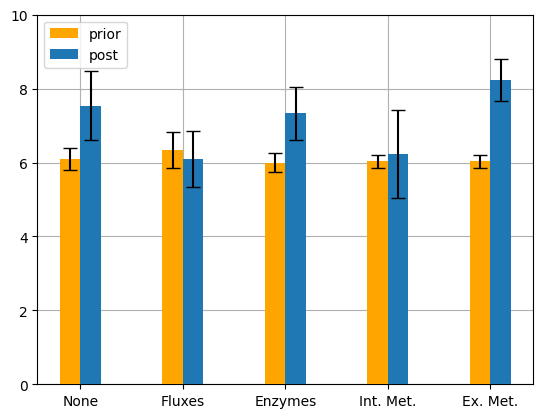

In [ ]:
ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int. Met.', 'Ex. Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend()
plt.savefig(f'../data/results/raw_svg_figures/top{topology}_rankCounts.svg', format='svg')

C:\Users\user\AppData\Local\Temp\ipykernel_7944\694365876.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_7944\694365876.py:1: FutureWarning:

The operation <function std at 0x00000241FF8BB1F0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.

C:\Users\user\AppData\Local\Temp\ipykernel_7944\694365876.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



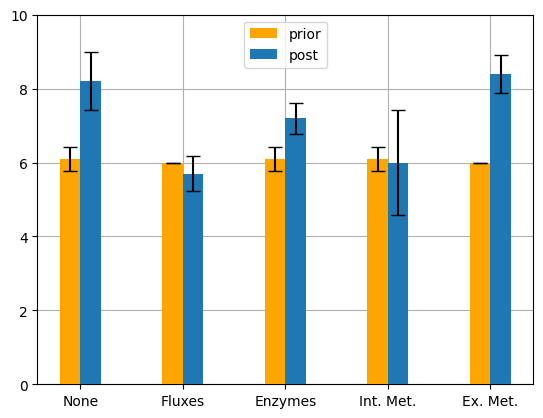

In [14]:
stagbar_counts = rank_counts_df[rank_counts_df['regulation']=='noReg'].pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])

ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int. Met.', 'Ex. Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend()
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-noReg_rankCounts.svg', format='svg')

C:\Users\user\AppData\Local\Temp\ipykernel_7944\2509773324.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_7944\2509773324.py:1: FutureWarning:

The operation <function std at 0x00000241FF8BB1F0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.

C:\Users\user\AppData\Local\Temp\ipykernel_7944\2509773324.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



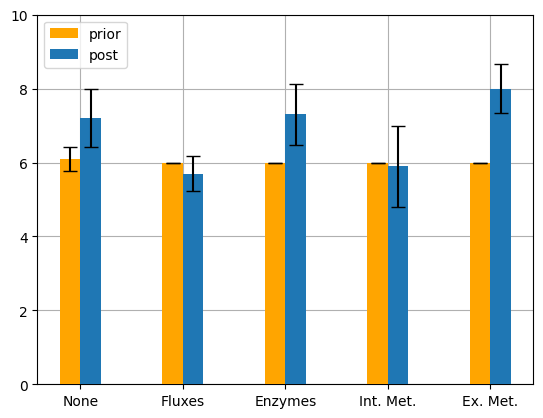

In [15]:
stagbar_counts = rank_counts_df[rank_counts_df['regulation']=='reg1'].pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])

ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int. Met.', 'Ex. Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend()
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-reg1_rankCounts.svg', format='svg')

C:\Users\user\AppData\Local\Temp\ipykernel_7944\807162765.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.

C:\Users\user\AppData\Local\Temp\ipykernel_7944\807162765.py:1: FutureWarning:

The operation <function std at 0x00000241FF8BB1F0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.

C:\Users\user\AppData\Local\Temp\ipykernel_7944\807162765.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



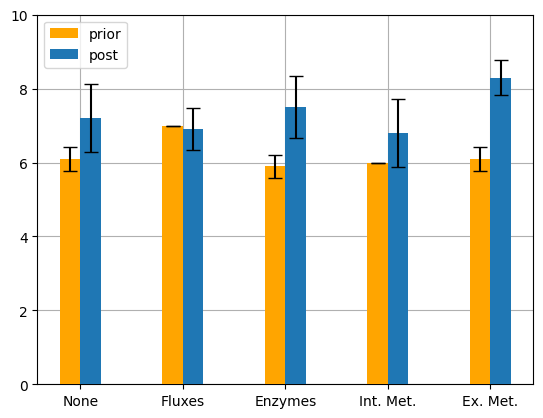

In [16]:
stagbar_counts = rank_counts_df[rank_counts_df['regulation']=='reg2'].pivot_table(index=['omittedData','type'], aggfunc=['mean',np.std])
stagbar_counts.reset_index(inplace=True)
stagbar_counts = stagbar_counts.reindex([1,0,7,6,3,2,9,8,5,4])

ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values,
        width=0.2, color='orange', align='center', zorder=100, label='prior')
plt.errorbar([i-0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='prior']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='prior']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

ax.bar([i+0.1 for i in range(5)], stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values,
        width=0.2, color='tab:blue', align='center', zorder=100, label='post')
plt.errorbar([i+0.1 for i in range(5)], 
             stagbar_counts[stagbar_counts['type']=='post']['mean']['count'].values, 
             yerr=stagbar_counts[stagbar_counts['type']=='post']['std']['count'].values, 
             ls='none', color='black', capsize=5, zorder=1000)

_ = ax.set_xticklabels([0, 'None', 'Fluxes', 'Enzymes', 'Int. Met.', 'Ex. Met.'])
_ = ax.set_yticks(range(0,12,2))
ax.legend()
plt.savefig(f'../data/results/raw_svg_figures/top{topology}-reg2_rankCounts.svg', format='svg')

# Old Analyses

## Visualizing Spearman data 

### Condense Spearman data

In [125]:
os.chdir(f'../data/results/spearman_coefficients/topology{topology}/')

In [126]:
spr_file_list = [i for i in os.listdir()]

spr_dfs = []
for file in spr_file_list:
    a = pd.read_csv(file)

    reg = file.split('-')[1].split('_')[0]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    spr_dfs.append(a)

all_spr_df_B = pd.concat(spr_dfs)
all_spr_df_B

,Unnamed: 0,r,p-value,lower,upper,reg,omit
0,0.1x-prior,0.318885,0.197128,-0.192491,0.750293,noReg,allData
1,0.2x-prior,0.285862,0.250170,-0.256156,0.726530,noReg,allData
2,0.3x-prior,0.234262,0.349454,-0.367276,0.681976,noReg,allData
3,0.4x-prior,0.250774,0.315513,-0.319241,0.699851,noReg,allData
4,0.5x-prior,0.170279,0.499341,-0.375305,0.633770,noReg,allData
...,...,...,...,...,...,...,...
15,1.5x-post,0.591331,0.009747,0.077044,0.853485,reg2,omitIntMet
16,3x-post,0.413829,0.087785,-0.078306,0.745657,reg2,omitIntMet
17,5x-post,0.659443,0.002909,0.276142,0.841506,reg2,omitIntMet
18,7x-post,0.310630,0.209625,-0.202747,0.699687,reg2,omitIntMet


In [127]:
os.chdir('../../../../notebooks/')

In [128]:
all_spr_df_B.rename(columns={'Unnamed: 0':'perturbation'}, inplace=True)
all_spr_df_B['distr'] = [(i.split('-')[1]) for i in all_spr_df_B['perturbation']]
all_spr_df_B['perturbation'] = [float(i.split('x')[0]) for i in all_spr_df_B['perturbation']]

In [129]:
all_spr_df_B = all_spr_df_B[all_spr_df_B['perturbation'] != 1.01]
all_spr_df_B

,perturbation,r,p-value,lower,upper,reg,omit,distr
0,0.1,0.318885,0.197128,-0.192491,0.750293,noReg,allData,prior
1,0.2,0.285862,0.250170,-0.256156,0.726530,noReg,allData,prior
2,0.3,0.234262,0.349454,-0.367276,0.681976,noReg,allData,prior
3,0.4,0.250774,0.315513,-0.319241,0.699851,noReg,allData,prior
4,0.5,0.170279,0.499341,-0.375305,0.633770,noReg,allData,prior
...,...,...,...,...,...,...,...,...
15,1.5,0.591331,0.009747,0.077044,0.853485,reg2,omitIntMet,post
16,3.0,0.413829,0.087785,-0.078306,0.745657,reg2,omitIntMet,post
17,5.0,0.659443,0.002909,0.276142,0.841506,reg2,omitIntMet,post
18,7.0,0.310630,0.209625,-0.202747,0.699687,reg2,omitIntMet,post


In [159]:
a = pd.pivot_table(all_spr_df_B, values=['r'], index=['omit', 'distr'], aggfunc=['mean', 'std'], sort=False)
a.reset_index(inplace=True)
a = a.reindex([0,1,6,7,2,3,8,9,4,5])
a

,omit,distr,mean,std
,,,r,r
0,allData,prior,0.237633,0.085741
1,allData,post,0.594840,0.218064
6,omitFluxes,prior,0.162986,0.057776
7,omitFluxes,post,0.273959,0.045960
2,omitEnzymes,prior,0.214792,0.062460
3,omitEnzymes,post,0.525077,0.160080
8,omitIntMet,prior,0.219264,0.051822
9,omitIntMet,post,0.307878,0.268801
4,omitExMet,prior,0.219264,0.057713


### Graph of aggregated Spearman corr

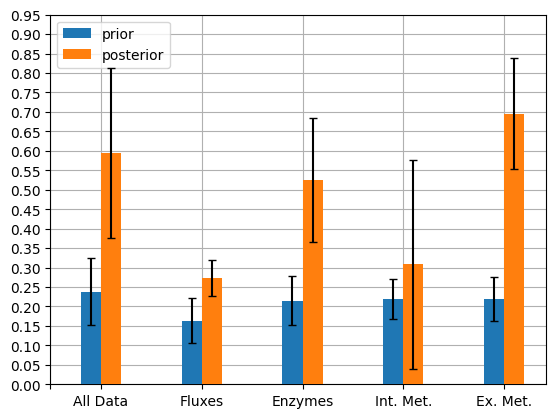

In [163]:
# plot
ax = plt.subplot(111)
ax.grid()

ax.bar([i-0.1 for i in range(5)], a[a['distr']=='prior']['mean'].squeeze(), width=0.2, color='tab:blue', align='center', zorder=100, label='prior')
ax.bar([i+0.1 for i in range(5)], a[a['distr']=='post']['mean'].squeeze(), width=0.2, color='tab:orange', align='center', zorder=100, label='posterior')

## add error bars
plt.errorbar([i-0.1 for i in range(5)], a[a['distr']=='prior']['mean'].squeeze(), 
             yerr=a[a['distr']=='prior']['std'].squeeze(), 
             color='black', capsize=3, zorder=1000, ls='none')

plt.errorbar([i+0.1 for i in range(5)], a[a['distr']=='post']['mean'].squeeze(), 
             yerr=a[a['distr']=='post']['std'].squeeze(), 
             color='black', capsize=3, zorder=1000, ls='none')

ax.set_xticks([-0.5]+list(np.arange(0,5)))
_ = ax.set_xticklabels(['', 'All Data', "Fluxes", 'Enzymes', "Int. Met.", "Ex. Met."]) ## fix the labels
_ = ax.set_yticks(np.arange(0,1,0.05))

ax.legend()

plt.savefig(f'../data/results/raw_svg_figures/Top{topology}_sprCorr.svg', format='svg' )

In [ ]:
fluxes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitFluxes']))]
enzymes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitEnzymes']))]
intMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitIntMet']))]
exMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitExMet']))]

### All-in-one scatter plots

In [ ]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='noReg')], 'Spearman rank coefficients, noReg')

In [ ]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg1')], 'Spearman rank coefficients, reg1')

In [ ]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2')], 'Spearman rank coefficients, reg2')

## Visualizing MAE across the different types of data

In [119]:
os.chdir('../data/results/MAE/')
MAE_file_list = [i for i in os.listdir() if "topologyB" in i]

MAE_dfs = []
for file in MAE_file_list:
    b = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    b['reg'] = [reg]*len(b)
    b['omit'] = [omit]*len(b)
    MAE_dfs.append(b)

all_MAE_df_B = pd.concat(MAE_dfs)
all_MAE_df_B

os.chdir('../../../notebooks/')


In [120]:
all_MAE_df_B.columns = ['perturbation', 'values', 'reg', 'omit']
all_MAE_df_B['values'] = all_MAE_df_B['values']/247
all_MAE_df_B

,perturbation,values,reg,omit
0,gt,0.000000,noReg,allData-hp
1,0.1x,0.000233,noReg,allData-hp
2,0.2x,0.000290,noReg,allData-hp
3,0.3x,0.000347,noReg,allData-hp
4,0.4x,0.000421,noReg,allData-hp
...,...,...,...,...
6,1.5x,0.002084,reg2,omitIntMet
7,3x,0.002063,reg2,omitIntMet
8,5x,0.002039,reg2,omitIntMet
9,7x,0.001962,reg2,omitIntMet


In [121]:
# a = all_MAE_df_B.pivot(index=['omit', 'reg'], columns='perturbation', values='values')

all_MAE_df_B = all_MAE_df_B[all_MAE_df_B['perturbation'] != 1.01]
all_MAE_df_B = all_MAE_df_B[all_MAE_df_B['perturbation'] != 'knockout']


C:\Users\user\AppData\Local\Temp\ipykernel_27376\2885349465.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, B-noReg')

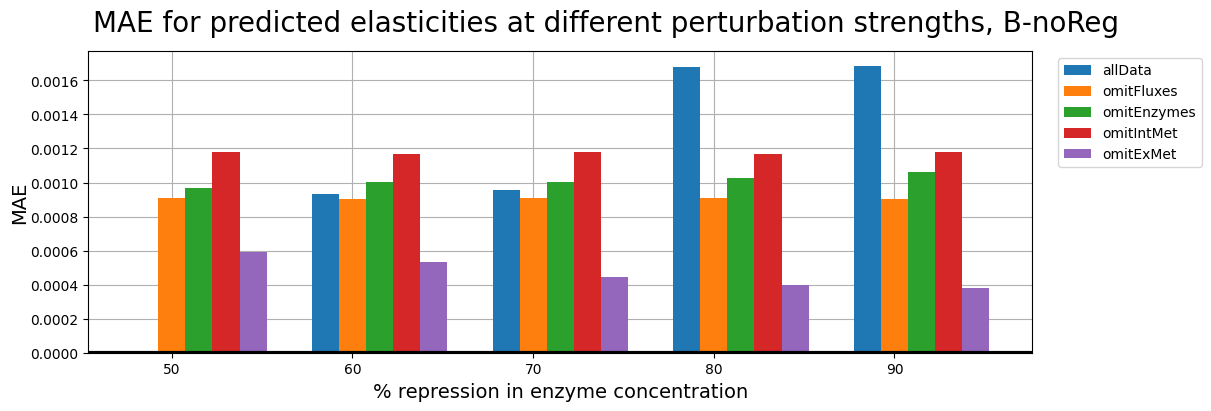

In [122]:
noReg_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'noReg']
noReg_df['r'] = noReg_df['values'].round(3)
noReg_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)

ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, B-noReg", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_27376\1654470176.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, B-reg1')

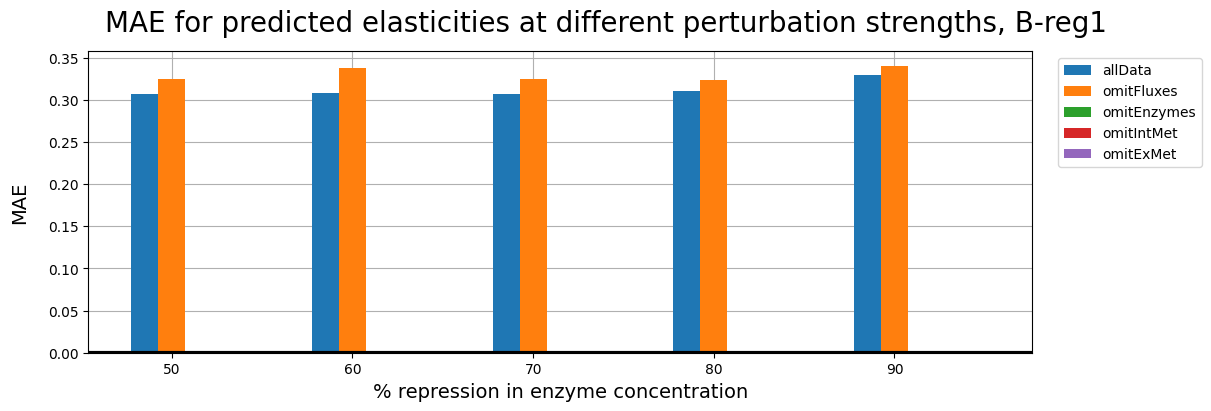

In [123]:
reg1_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'reg1']
reg1_df['r'] = reg1_df['values'].round(3)
reg1_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)

ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, B-reg1", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_27376\3502383712.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, B-reg2')

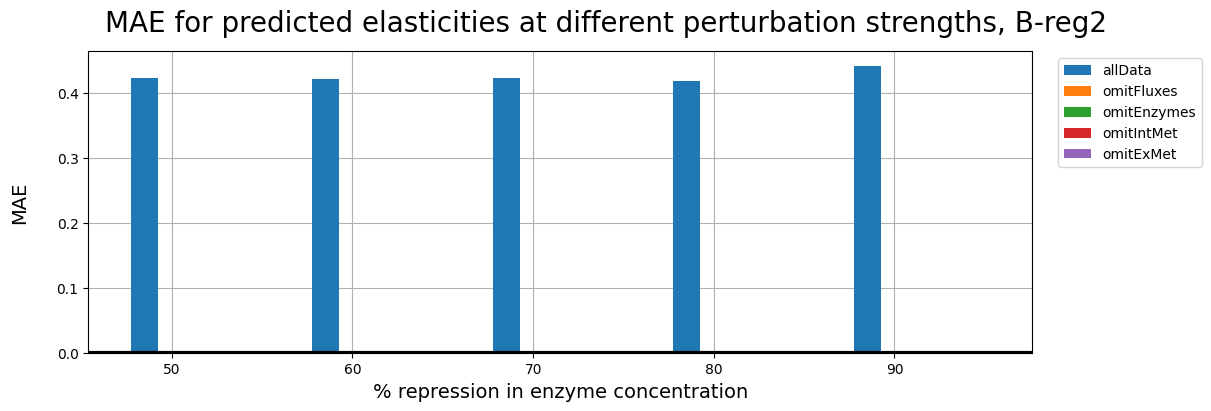

In [124]:
reg2_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'reg2']
reg2_df['r'] = reg2_df['values'].round(3)
reg2_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, B-reg2", size=20)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (10,).

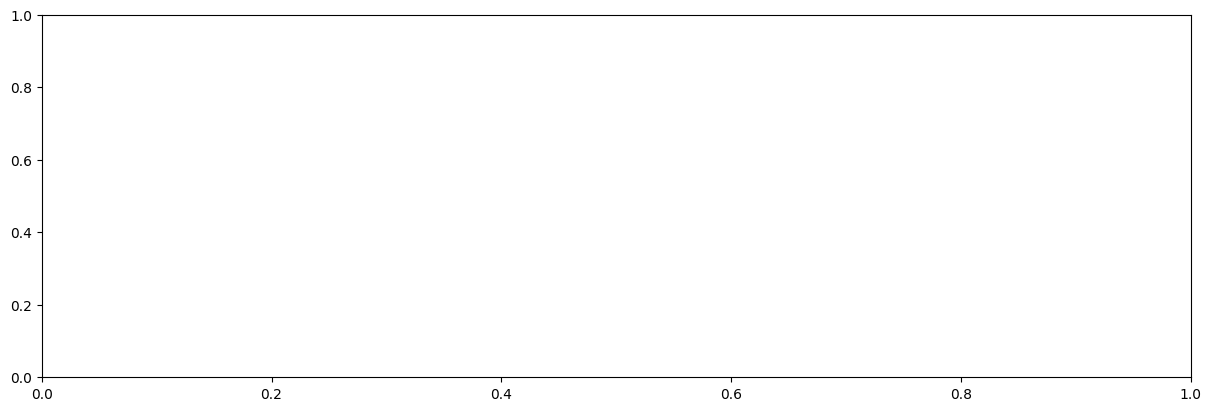

In [125]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, B-noReg", size=20)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (5,).

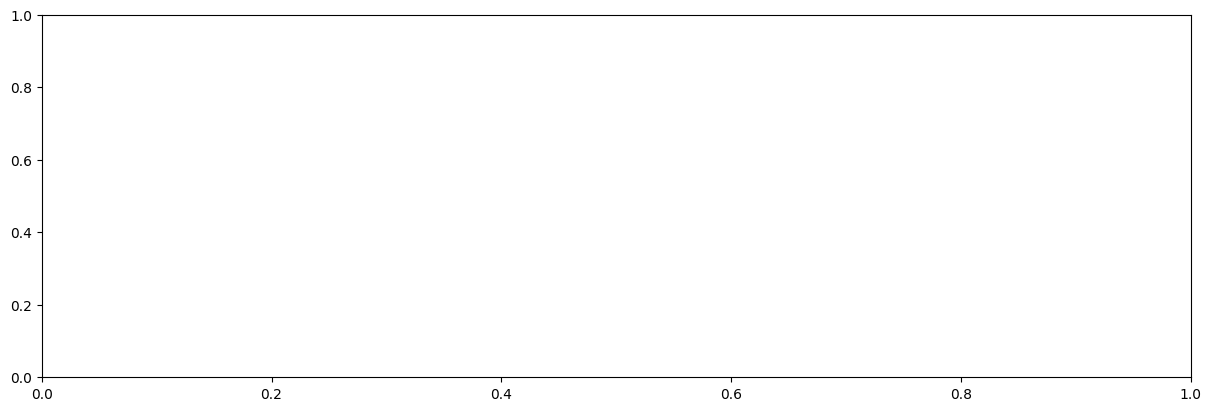

In [126]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, B-reg1", size=20)


In [ ]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, B-reg2", size=20)


## Comparing Spearman r coefficients pairwise to find significant differences

In [ ]:
def plot_CI_comparisons(subplot, omitted_type, reg_level, CRISPRi=True, color='orange'):

    if CRISPRi: 
        df1 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']=='allData')][0:5]
        df2 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']==f'omit{omitted_type}')][0:5]

        x1 = np.linspace(90,50,5)
        x2 = np.linspace(90,50,5)

    else:
        df1 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']=='allData')][5:10]
        df2 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']==f'omit{omitted_type}')][5:10]

        x1 = df1['perturbation']
        x2 = df2['perturbation']

    ymin1 = (df1['r'] - df1['lower']).values
    ymax1 = (df1['upper'] - df1['r']).values

    ymin2 = (df2['r'] - df2['lower']).values
    ymax2 = (df2['upper'] - df2['r']).values

    subplot.scatter(x1, 
                abs(df1['r']), alpha=0.8, s=40, zorder=1000, label='all data', 
                color='red')
    subplot.errorbar(x1, df1['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None', color='red', zorder=100)

    subplot.scatter(x2, 
                abs(df2['r']), alpha=0.8, s=100, zorder=50, 
                label=f'omit {omitted_type}', c=color)
    subplot.errorbar(x2, df2['r'], yerr=np.stack((ymin2, ymax2)), 
                 elinewidth=6, linestyle='None', c=color, zorder=10,
                 alpha=0.8)

    subplot.grid(True, which='both', axis='both', zorder=0)
    subplot.set_ylim([0,1])
        

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg")
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg")
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg")
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg")
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", color='blue')

fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("TopologyB--Comparing CRISPRi datasets with omitted data at different regulation levels", size=20)


In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", CRISPRi=False, color='blue')


fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("TopologyB--Comparing CRISPRa datasets with omitted data at different regulations levels", size=20)


## Comprehensive bar plots

In [ ]:
B_noReg_df = all_spr_df_B[all_spr_df_B['reg'] == 'noReg']
B_noReg_df['r'] = B_noReg_df['r'].round(3)
B_noReg_df['ymin'] = B_noReg_df['r'] - B_noReg_df['lower']
B_noReg_df['ymax'] = B_noReg_df['upper'] - B_noReg_df['r']

B_reg1_df = all_spr_df_B[all_spr_df_B['reg'] == 'reg1']
B_reg1_df['r'] = B_reg1_df['r'].round(3)
B_reg1_df['ymin'] = B_reg1_df['r'] - B_reg1_df['lower']
B_reg1_df['ymax'] = B_reg1_df['upper'] - B_reg1_df['r']

B_reg2_df = all_spr_df_B[all_spr_df_B['reg'] == 'reg2']
B_reg2_df['r'] = B_reg2_df['r'].round(3)
B_reg2_df['ymin'] = B_reg2_df['r'] - B_reg2_df['lower']
B_reg2_df['ymax'] = B_reg2_df['upper'] - B_reg2_df['r']

In [ ]:
species = list(B_noReg_df['perturbation'].unique()[0:5])[::-1]

# these are the r values for CRISPRi, but in reverse order
penguin_means = {
    'allData': tuple((B_noReg_df[B_noReg_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ymin = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymin']).values[0:5])[::-1]
    ymax = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymax']).values[0:5])[::-1]
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
# plt.ylim((0,1))
plt.ylim((-0.7,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-noReg", size=20)


In [ ]:
species = B_noReg_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_noReg_df[B_noReg_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitExMet']['r']).values[5:10])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    
    ymin = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymin']).values[5:10])[::-1]
    ymax = ((B_noReg_df[B_noReg_df['omit'] == attribute]['ymax']).values[5:10])[::-1]
    
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-noReg", size=20)


In [ ]:
species = list(B_reg1_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((B_reg1_df[B_reg1_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymin']).values[0:5])[::-1]
    ymax = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymax']).values[0:5])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg1", size=20)


In [ ]:
species = B_reg1_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_reg1_df[B_reg1_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitExMet']['r']).values[5:10])
}


x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymin']).values[5:10])[::-1]
    ymax = ((B_reg1_df[B_reg1_df['omit'] == attribute]['ymax']).values[5:10])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg1", size=20)


In [ ]:
species = list(B_reg2_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((B_reg2_df[B_reg2_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymin']).values[0:5])[::-1]
    ymax = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymax']).values[0:5])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg2", size=20)


In [ ]:
species = B_reg2_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_reg2_df[B_reg2_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitExMet']['r']).values[5:10])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier

    ymin = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymin']).values[5:10])[::-1]
    ymax = ((B_reg2_df[B_reg2_df['omit'] == attribute]['ymax']).values[5:10])[::-1]

    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg2", size=20)


## Make tables of ranking correctness

In [ ]:
os.chdir('../data/results/rankings/')

In [ ]:
rank_file_list = [i for i in os.listdir() if "topologyB" in i]

rank_dfs = []
for file in rank_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    rank_dfs.append(a)

all_rank_df_B = pd.concat(rank_dfs)# .drop('1.01x', axis=1)
all_rank_df_B

In [ ]:
os.chdir('../../../notebooks/')

#### Counts of top three ranked FCCs

In [ ]:
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [ ]:
topThree_df = all_rank_df_B[all_rank_df_B['v19'].isin([1, 2, 3])]

gt_ranks = all_rank_df_B['gt'].head(19)

rank_noReg = topThree_df[topThree_df['reg']=='noReg']#.drop('gt', axis=1)
rank_reg1 = topThree_df[topThree_df['reg']=='reg1']#.drop('gt', axis=1)
rank_reg2 = topThree_df[topThree_df['reg']=='reg2']#.drop('gt', axis=1)

In [ ]:
rank_noReg

In [ ]:
gt_t3 = rank_noReg.groupby('omit')['gt'].apply(list).reset_index()
gt_t3_sets = np.where(gt_t3['gt']=='','', gt_t3['gt'].map(set))
gt_t3_sets

t3_sets = []
for pt in pt_labels: 
    t3 = rank_noReg.groupby('omit')[pt].apply(list).reset_index()
    t3_sets.append(np.where(t3[pt]=='','', t3[pt].map(set)))

scores=[]
for i in t3_sets: 
    for ii, gt_t3 in enumerate(gt_t3_sets): 
        scores.append(len(set.intersection(gt_t3, i[ii])))

t3_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t3_results

In [ ]:
gt_t3 = rank_reg1.groupby('omit')['gt'].apply(list).reset_index()
gt_t3_sets = np.where(gt_t3['gt']=='','', gt_t3['gt'].map(set))
gt_t3_sets

t3_sets = []
for pt in pt_labels: 
    t3 = rank_reg1.groupby('omit')[pt].apply(list).reset_index()
    t3_sets.append(np.where(t3[pt]=='','', t3[pt].map(set)))

scores=[]
for i in t3_sets: 
    for ii, gt_t3 in enumerate(gt_t3_sets): 
        scores.append(len(set.intersection(gt_t3, i[ii])))

t3_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t3_results

In [ ]:
gt_t3 = rank_reg2.groupby('omit')['gt'].apply(list).reset_index()
gt_t3_sets = np.where(gt_t3['gt']=='','', gt_t3['gt'].map(set))
gt_t3_sets

t3_sets = []
for pt in pt_labels: 
    t3 = rank_reg2.groupby('omit')[pt].apply(list).reset_index()
    t3_sets.append(np.where(t3[pt]=='','', t3[pt].map(set)))

scores=[]
for i in t3_sets: 
    for ii, gt_t3 in enumerate(gt_t3_sets): 
        scores.append(len(set.intersection(gt_t3, i[ii])))

t3_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t3_results

In [ ]:
# visualizations. Heatmaps?

#### Counts of top five ranked FCCs

In [ ]:
topFive_df = all_rank_df_B[all_rank_df_B['v19'].isin([1, 2, 3, 4, 5])]

gt_ranks_5 = all_rank_df_B['gt'].head(19)

rank_noReg_5 = topFive_df[topFive_df['reg']=='noReg']#.drop('gt', axis=1)
rank_reg1_5 = topFive_df[topFive_df['reg']=='reg1']#.drop('gt', axis=1)
rank_reg2_5 = topFive_df[topFive_df['reg']=='reg2']#.drop('gt', axis=1)

In [ ]:
gt_t5 = rank_noReg_5.groupby('omit')['gt'].apply(list).reset_index()
gt_t5_sets = np.where(gt_t5['gt']=='','', gt_t5['gt'].map(set))
gt_t5_sets

t5_sets = []
for pt in pt_labels: 
    t5 = rank_noReg_5.groupby('omit')[pt].apply(list).reset_index()
    t5_sets.append(np.where(t5[pt]=='','', t5[pt].map(set)))

scores=[]
for i in t5_sets: 
    for ii, gt_t5 in enumerate(gt_t5_sets): 
        scores.append(len(set.intersection(gt_t5, i[ii])))

t5_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t5_results

In [ ]:
gt_t5 = rank_reg1_5.groupby('omit')['gt'].apply(list).reset_index()
gt_t5_sets = np.where(gt_t5['gt']=='','', gt_t5['gt'].map(set))
gt_t5_sets

t5_sets = []
for pt in pt_labels: 
    t5 = rank_reg1_5.groupby('omit')[pt].apply(list).reset_index()
    t5_sets.append(np.where(t5[pt]=='','', t5[pt].map(set)))

scores=[]
for i in t5_sets: 
    for ii, gt_t5 in enumerate(gt_t5_sets): 
        scores.append(len(set.intersection(gt_t5, i[ii])))

t5_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t5_results

In [ ]:
gt_t5 = rank_reg2_5.groupby('omit')['gt'].apply(list).reset_index()
gt_t5_sets = np.where(gt_t5['gt']=='','', gt_t5['gt'].map(set))
gt_t5_sets

t5_sets = []
for pt in pt_labels: 
    t5 = rank_reg2_5.groupby('omit')[pt].apply(list).reset_index()
    t5_sets.append(np.where(t5[pt]=='','', t5[pt].map(set)))

scores=[]
for i in t5_sets: 
    for ii, gt_t5 in enumerate(gt_t5_sets): 
        scores.append(len(set.intersection(gt_t5, i[ii])))

t5_results = pd.DataFrame((np.array(scores)).reshape((len(pt_labels),-1)).T, 
             index=all_rank_df_B['omit'].unique(), columns=pt_labels)
t5_results

In [ ]:
## 

## How does the presence of regulators affect BMCA’s performance?


In [ ]:
picklefolder = '../data/results/tracePickles/'
oldpicklefolder = '../data/results/tracePickles-20240801/'

In [ ]:
with gzip.open(picklefolder + 'topologyB-noReg_omitExMet_traces.pgz', "rb") as f:
    traces_noReg = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + 'topologyB-reg1_omitExMet_traces.pgz', "rb") as f:
    traces_reg1 = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + 'topologyB-reg2_omitExMet_traces.pgz', "rb") as f:
    traces_reg2 = cloudpickle.load(f, encoding='bytes')

In [ ]:
trace01_noReg=traces_noReg['trace01']
trace02_noReg=traces_noReg['trace02']
trace03_noReg=traces_noReg['trace03']
trace04_noReg=traces_noReg['trace04']
trace05_noReg=traces_noReg['trace05']
trace15_noReg=traces_noReg['trace15']
trace3_noReg=traces_noReg['trace3']
trace5_noReg=traces_noReg['trace5']
trace7_noReg=traces_noReg['trace7']
trace10_noReg=traces_noReg['trace100']

trace01_reg1=traces_reg1['trace01']
trace02_reg1=traces_reg1['trace02']
trace03_reg1=traces_reg1['trace03']
trace04_reg1=traces_reg1['trace04']
trace05_reg1=traces_reg1['trace05']
trace15_reg1=traces_reg1['trace15']
trace3_reg1=traces_reg1['trace3']
trace5_reg1=traces_reg1['trace5']
trace7_reg1=traces_reg1['trace7']
trace10_reg1=traces_reg1['trace100']

trace01_reg2=traces_reg2['trace01']
trace02_reg2=traces_reg2['trace02']
trace03_reg2=traces_reg2['trace03']
trace04_reg2=traces_reg2['trace04']
trace05_reg2=traces_reg2['trace05']
trace15_reg2=traces_reg2['trace15']
trace3_reg2=traces_reg2['trace3']
trace5_reg2=traces_reg2['trace5']
trace7_reg2=traces_reg2['trace7']
trace10_reg2=traces_reg2['trace100']

In [ ]:
a = util.get_az_mean(trace01_noReg)
aa = util.get_az_mean(trace01_reg1)
aaa = util.get_az_mean(trace01_reg2)

b = util.get_az_mean(trace02_noReg)
bb = util.get_az_mean(trace02_reg1)
bbb = util.get_az_mean(trace02_reg2)

c = util.get_az_mean(trace03_noReg)
cc = util.get_az_mean(trace03_reg1)
ccc = util.get_az_mean(trace03_reg2)

d = util.get_az_mean(trace04_noReg)
dd = util.get_az_mean(trace04_reg1)
ddd = util.get_az_mean(trace04_reg2)

e = util.get_az_mean(trace05_noReg)
ee = util.get_az_mean(trace05_reg1)
eee = util.get_az_mean(trace05_reg2)

f = util.get_az_mean(trace15_noReg)
ff = util.get_az_mean(trace15_reg1)
fff = util.get_az_mean(trace15_reg2)

g = util.get_az_mean(trace3_noReg)
gg = util.get_az_mean(trace3_reg1)
ggg = util.get_az_mean(trace3_reg2)

h = util.get_az_mean(trace5_noReg)
hh = util.get_az_mean(trace5_reg1)
hhh = util.get_az_mean(trace5_reg2)

i = util.get_az_mean(trace7_noReg)
ii = util.get_az_mean(trace7_reg1)
iii = util.get_az_mean(trace7_reg2)

j = util.get_az_mean(trace10_noReg)
jj = util.get_az_mean(trace10_reg1)
jjj = util.get_az_mean(trace10_reg2)

In [ ]:
print(round(sp.stats.f_oneway(a,aa,aaa)[0],3))
print(round(sp.stats.f_oneway(b,bb,bbb)[0],3))
print(round(sp.stats.f_oneway(c,cc,ccc)[0],3))
print(round(sp.stats.f_oneway(d,dd,ddd)[0],3))
print(round(sp.stats.f_oneway(e,ee,eee)[0],3))
print(round(sp.stats.f_oneway(f,ff,fff)[0],3))
print(round(sp.stats.f_oneway(g,gg,ggg)[0],3))
print(round(sp.stats.f_oneway(h,hh,hhh)[0],3))
print(round(sp.stats.f_oneway(i,ii,iii)[0],3))
print(round(sp.stats.f_oneway(j,jj,jjj)[0],3))
print('\n')
print(round(sp.stats.f_oneway(a,aa,aaa)[1],3))
print(round(sp.stats.f_oneway(b,bb,bbb)[1],3))
print(round(sp.stats.f_oneway(c,cc,ccc)[1],3))
print(round(sp.stats.f_oneway(d,dd,ddd)[1],3))
print(round(sp.stats.f_oneway(e,ee,eee)[1],3))
print(round(sp.stats.f_oneway(f,ff,fff)[1],3))
print(round(sp.stats.f_oneway(g,gg,ggg)[1],3))
print(round(sp.stats.f_oneway(h,hh,hhh)[1],3))
print(round(sp.stats.f_oneway(i,ii,iii)[1],3))
print(round(sp.stats.f_oneway(j,jj,jjj)[1],3))

## graphing the elasticity predictions over perturbation level and regulator level

In [ ]:
picklefolder = '../data/results/tracePickles/'
oldpicklefolder = '../data/results/tracePickles-20240801/'

In [ ]:
omission='allData'

In [ ]:
with gzip.open(picklefolder + f'TopologyB-noReg_{omission}_traces.pgz', "rb") as f:
    traces_noReg = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + f'TopologyB-reg1_{omission}_traces.pgz', "rb") as f:
    traces_reg1 = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + f'TopologyB-reg2_{omission}_traces.pgz', "rb") as f:
    traces_reg2 = cloudpickle.load(f, encoding='bytes')

In [ ]:
trace01_noReg=traces_noReg['trace01']
trace02_noReg=traces_noReg['trace02']
trace03_noReg=traces_noReg['trace03']
trace04_noReg=traces_noReg['trace04']
trace05_noReg=traces_noReg['trace05']
trace15_noReg=traces_noReg['trace15']
trace3_noReg=traces_noReg['trace3']
trace5_noReg=traces_noReg['trace5']
trace7_noReg=traces_noReg['trace7']
trace10_noReg=traces_noReg['trace100']

trace01_reg1=traces_reg1['trace01']
trace02_reg1=traces_reg1['trace02']
trace03_reg1=traces_reg1['trace03']
trace04_reg1=traces_reg1['trace04']
trace05_reg1=traces_reg1['trace05']
trace15_reg1=traces_reg1['trace15']
trace3_reg1=traces_reg1['trace3']
trace5_reg1=traces_reg1['trace5']
trace7_reg1=traces_reg1['trace7']
trace10_reg1=traces_reg1['trace100']

trace01_reg2=traces_reg2['trace01']
trace02_reg2=traces_reg2['trace02']
trace03_reg2=traces_reg2['trace03']
trace04_reg2=traces_reg2['trace04']
trace05_reg2=traces_reg2['trace05']
trace15_reg2=traces_reg2['trace15']
trace3_reg2=traces_reg2['trace3']
trace5_reg2=traces_reg2['trace5']
trace7_reg2=traces_reg2['trace7']
trace10_reg2=traces_reg2['trace100']

In [ ]:
Ex01_noReg = util.get_az_summary(trace01_noReg)
Ex01_reg1 = util.get_az_summary(trace01_reg1)
Ex01_reg2 = util.get_az_summary(trace01_reg2)

Ex02_noReg = util.get_az_summary(trace02_noReg)
Ex02_reg1 = util.get_az_summary(trace02_reg1)
Ex02_reg2 = util.get_az_summary(trace02_reg2)

Ex03_noReg = util.get_az_summary(trace03_noReg)
Ex03_reg1 = util.get_az_summary(trace03_reg1)
Ex03_reg2 = util.get_az_summary(trace03_reg2)

Ex04_noReg = util.get_az_summary(trace04_noReg)
Ex04_reg1 = util.get_az_summary(trace04_reg1)
Ex04_reg2 = util.get_az_summary(trace04_reg2)

Ex05_noReg = util.get_az_summary(trace05_noReg)
Ex05_reg1 = util.get_az_summary(trace05_reg1)
Ex05_reg2 = util.get_az_summary(trace05_reg2)

Ex15_noReg = util.get_az_summary(trace15_noReg)
Ex15_reg1 = util.get_az_summary(trace15_reg1)
Ex15_reg2 = util.get_az_summary(trace15_reg2)

Ex3_noReg = util.get_az_summary(trace3_noReg)
Ex3_reg1 = util.get_az_summary(trace3_reg1)
Ex3_reg2 = util.get_az_summary(trace3_reg2)

Ex5_noReg = util.get_az_summary(trace5_noReg)
Ex5_reg1 = util.get_az_summary(trace5_reg1)
Ex5_reg2 = util.get_az_summary(trace5_reg2)

Ex7_noReg = util.get_az_summary(trace7_noReg)
Ex7_reg1 = util.get_az_summary(trace7_reg1)
Ex7_reg2 = util.get_az_summary(trace7_reg2)

Ex100_noReg = util.get_az_summary(trace10_noReg)
Ex100_reg1 = util.get_az_summary(trace10_reg1)
Ex100_reg2 = util.get_az_summary(trace10_reg2)

In [ ]:
ela_noReg_values = np.column_stack([Ex01_noReg, Ex02_noReg, Ex03_noReg, 
                                Ex04_noReg, Ex05_noReg,  
                                Ex15_noReg, Ex3_noReg, Ex5_noReg, 
                                Ex7_noReg, Ex100_noReg])

ela_reg1_values = np.column_stack([Ex01_reg1, Ex02_reg1, Ex03_reg1, 
                                Ex04_reg1, Ex05_reg1,  
                                Ex15_reg1, Ex3_reg1, Ex5_reg1, 
                                Ex7_reg1, Ex100_reg1])

ela_reg2_values = np.column_stack([Ex01_reg2, Ex02_reg2, Ex03_reg2, 
                                Ex04_reg2, Ex05_reg2,  
                                Ex15_reg2, Ex3_reg2, Ex5_reg2, 
                                Ex7_reg2, Ex100_reg2])

pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

ela_noReg_df = pd.DataFrame(ela_noReg_values, columns=pt_labels)
ela_reg1_df = pd.DataFrame(ela_reg1_values, columns=pt_labels)
ela_reg2_df = pd.DataFrame(ela_reg2_values, columns=pt_labels)

ela_noReg_df['median'] = ela_noReg_df.median(axis=1)
ela_noReg_df['min'] = ela_noReg_df.min(axis=1)
ela_noReg_df['max'] = ela_noReg_df.max(axis=1)

ela_reg1_df['median'] = ela_reg1_df.median(axis=1)
ela_reg1_df['min'] = ela_reg1_df.min(axis=1)
ela_reg1_df['max'] = ela_reg1_df.max(axis=1)

ela_reg2_df['median'] = ela_reg2_df.median(axis=1)
ela_reg2_df['min'] = ela_reg2_df.min(axis=1)
ela_reg2_df['max'] = ela_reg2_df.max(axis=1)

In [ ]:
lower_y_noReg = np.array(ela_noReg_df['median']) - ela_noReg_df['min'].values
upper_y_noReg =np.array(ela_noReg_df['max'].values) - np.array(ela_noReg_df['median'])
errors_noReg = [lower_y_noReg, upper_y_noReg]

lower_y_reg1 = np.array(ela_reg1_df['median']) - ela_reg1_df['min'].values
upper_y_reg1 =np.array(ela_reg1_df['max'].values) - np.array(ela_reg1_df['median'])
errors_reg1 = [lower_y_reg1, upper_y_reg1]

lower_y_reg2 = np.array(ela_reg2_df['median']) - ela_reg2_df['min'].values
upper_y_reg2 =np.array(ela_reg2_df['max'].values) - np.array(ela_reg2_df['median'])
errors_reg2 = [lower_y_reg2, upper_y_reg2]


In [ ]:
Teusink_ant ='../models/Antimony/TopologyB.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()
gt = r.getScaledElasticityMatrix().ravel()

In [ ]:
round(sum(abs(ela_noReg_df['median']-gt))/len(gt),5)